In [14]:
# import torch
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import pickle
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sn
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from resnet import resnet10, resnet18
from resxnet import ResNeXt29_2x64d, ResNeXt29_32x4d
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torchsummary import summary
from senet import se_resnet20, se_resnet56, se_preactresnet56
from efficientnet import EfficientNetB0
from shufflenet import ShuffleNetV2
from mobilenetv2 import MobileNetV2
from cnn import CNN_V3_V4
import pickle
import torchvision.models as models
from bit import KNOWN_MODELS

In [20]:
transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomRotation(25),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
        # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        transforms.RandomErasing(p=0.75, scale=(0.02, 0.1), value=1.0, inplace=False)
    ])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=4)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResNeXt29_32x4d().to(device)#resnet18().to(device) #(num_classes=10, reduction=16)

summary(model, input_size=(3, 32, 32))
# model.load_state_dict(torch.load('checkpoint/epoch47_resnext.tar'))

epochs = 500
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)#
# optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
# optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
# scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=1, eta_min=0, last_epoch=-1, verbose=True)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=10, verbose=True)
patience = 10  # Stop if no improvement for 'patience' epochs
best_loss = float("inf")
epochs_no_improve = 0
best_model_state = None
best_epoch = 0
train_loss_history = []
train_accu_history = []
test_loss_history = []
test_accu_history = []


for epoch in range(epochs):
    print("epoch:", epoch, 'lr', optimizer.param_groups[0]['lr'])
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    # progress_bar = tqdm(trainloader, desc=f"Epoch {epoch + 1}/{epochs}")
    for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        # progress_bar.update(1)
        # progress_bar.set_postfix(loss=(train_loss/(batch_idx+1)))

    torch.save(model.state_dict(), 'checkpoint/epoch' + str(epoch) + '.tar')

    print('Train Loss: ', train_loss/(batch_idx+1), ' Acc: ', 100.*correct/total, ' correct: ', correct, ' total: ', total)
    train_accu_history += [100. * correct / total]
    #test
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    scheduler.step(1-correct / total)

    print(f"Test Accuracy: {100 * correct / total:.2f}%, Test Loss: {test_loss / (batch_idx + 1):.4f}")
    train_loss = train_loss / len(trainloader)
    test_loss = test_loss / len(testloader)
    train_loss_history += [train_loss]
    test_accu_history += [100. * correct / total]
    test_loss_history += [test_loss]
    if test_loss < best_loss:
        best_loss = test_loss
        best_epoch = epoch
        epochs_no_improve = 0
        best_model_state = model.state_dict()  # Save best model
    else:
        epochs_no_improve += 1
        

Files already downloaded and verified
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             192
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3          [-1, 128, 32, 32]           8,192
       BatchNorm2d-4          [-1, 128, 32, 32]             256
            Conv2d-5          [-1, 128, 32, 32]           4,608
       BatchNorm2d-6          [-1, 128, 32, 32]             256
            Conv2d-7          [-1, 256, 32, 32]          32,768
       BatchNorm2d-8          [-1, 256, 32, 32]             512
            Conv2d-9          [-1, 256, 32, 32]          16,384
      BatchNorm2d-10          [-1, 256, 32, 32]             512
            Block-11          [-1, 256, 32, 32]               0
           Conv2d-12          [-1, 128, 32, 32]          32,768
      BatchNorm2d-13       

100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  1.676339665947058  Acc:  38.69  correct:  19345  total:  50000
Test Accuracy: 54.30%, Test Loss: 1.2756
epoch: 1 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  1.2525137827524444  Acc:  55.166  correct:  27583  total:  50000
Test Accuracy: 63.06%, Test Loss: 1.0953
epoch: 2 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  1.0615959771148993  Acc:  62.352  correct:  31176  total:  50000
Test Accuracy: 58.13%, Test Loss: 1.6057
epoch: 3 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.9377273891283118  Acc:  67.112  correct:  33556  total:  50000
Test Accuracy: 70.57%, Test Loss: 0.8726
epoch: 4 lr 0.001


100%|██████████| 391/391 [01:07<00:00,  5.82it/s]


Train Loss:  0.8542808577837542  Acc:  69.996  correct:  34998  total:  50000
Test Accuracy: 69.88%, Test Loss: 0.9880
epoch: 5 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.7863615534799483  Acc:  72.472  correct:  36236  total:  50000
Test Accuracy: 74.75%, Test Loss: 0.7714
epoch: 6 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.7420204909866118  Acc:  74.256  correct:  37128  total:  50000
Test Accuracy: 76.63%, Test Loss: 0.6971
epoch: 7 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.7050042019780639  Acc:  75.488  correct:  37744  total:  50000
Test Accuracy: 78.58%, Test Loss: 0.6299
epoch: 8 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.6730855422099228  Acc:  76.67  correct:  38335  total:  50000
Test Accuracy: 81.08%, Test Loss: 0.5662
epoch: 9 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.6415346498074739  Acc:  77.902  correct:  38951  total:  50000
Test Accuracy: 80.25%, Test Loss: 0.6171
epoch: 10 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.6277716604187665  Acc:  78.07  correct:  39035  total:  50000
Test Accuracy: 81.10%, Test Loss: 0.5472
epoch: 11 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.5996882812598782  Acc:  79.2  correct:  39600  total:  50000
Test Accuracy: 84.41%, Test Loss: 0.4562
epoch: 12 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.5855261697183789  Acc:  79.71  correct:  39855  total:  50000
Test Accuracy: 80.93%, Test Loss: 0.5706
epoch: 13 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.92it/s]


Train Loss:  0.5626167634411541  Acc:  80.392  correct:  40196  total:  50000
Test Accuracy: 82.30%, Test Loss: 0.5406
epoch: 14 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.5514296124810758  Acc:  80.864  correct:  40432  total:  50000
Test Accuracy: 82.77%, Test Loss: 0.5068
epoch: 15 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.5365675751053159  Acc:  81.324  correct:  40662  total:  50000
Test Accuracy: 83.61%, Test Loss: 0.4967
epoch: 16 lr 0.001


100%|██████████| 391/391 [01:05<00:00,  5.92it/s]


Train Loss:  0.5301045924044021  Acc:  81.6  correct:  40800  total:  50000
Test Accuracy: 85.33%, Test Loss: 0.4457
epoch: 17 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.5143158142371556  Acc:  82.098  correct:  41049  total:  50000
Test Accuracy: 85.19%, Test Loss: 0.4299
epoch: 18 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.4978748123206751  Acc:  82.792  correct:  41396  total:  50000
Test Accuracy: 82.13%, Test Loss: 0.5721
epoch: 19 lr 0.001


100%|██████████| 391/391 [01:07<00:00,  5.82it/s]


Train Loss:  0.4901806456048775  Acc:  83.086  correct:  41543  total:  50000
Test Accuracy: 85.86%, Test Loss: 0.4108
epoch: 20 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.86it/s]


Train Loss:  0.47886846856692866  Acc:  83.424  correct:  41712  total:  50000
Test Accuracy: 85.88%, Test Loss: 0.4199
epoch: 21 lr 0.001


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.47019859172803974  Acc:  83.798  correct:  41899  total:  50000
Test Accuracy: 85.38%, Test Loss: 0.4708
epoch: 22 lr 0.001


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.4664811041501477  Acc:  83.76  correct:  41880  total:  50000
Test Accuracy: 86.91%, Test Loss: 0.3819
epoch: 23 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.92it/s]


Train Loss:  0.45257379674850523  Acc:  84.224  correct:  42112  total:  50000
Test Accuracy: 85.10%, Test Loss: 0.4591
epoch: 24 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.45128879377909026  Acc:  84.458  correct:  42229  total:  50000
Test Accuracy: 87.43%, Test Loss: 0.3861
epoch: 25 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.43374487544264634  Acc:  84.872  correct:  42436  total:  50000
Test Accuracy: 86.69%, Test Loss: 0.4061
epoch: 26 lr 0.001


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.4341110590931095  Acc:  84.846  correct:  42423  total:  50000
Test Accuracy: 84.81%, Test Loss: 0.4642
epoch: 27 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.92it/s]


Train Loss:  0.42216632307490426  Acc:  85.152  correct:  42576  total:  50000
Test Accuracy: 86.69%, Test Loss: 0.4003
epoch: 28 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.92it/s]


Train Loss:  0.4218029624894452  Acc:  85.372  correct:  42686  total:  50000
Test Accuracy: 87.88%, Test Loss: 0.3599
epoch: 29 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.86it/s]


Train Loss:  0.4122457269512479  Acc:  85.702  correct:  42851  total:  50000
Test Accuracy: 88.80%, Test Loss: 0.3377
epoch: 30 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.4083332167104687  Acc:  85.99  correct:  42995  total:  50000
Test Accuracy: 88.07%, Test Loss: 0.3638
epoch: 31 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.4026786808848686  Acc:  86.048  correct:  43024  total:  50000
Test Accuracy: 88.83%, Test Loss: 0.3401
epoch: 32 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.3942402422504352  Acc:  86.216  correct:  43108  total:  50000
Test Accuracy: 87.26%, Test Loss: 0.3929
epoch: 33 lr 0.001


100%|██████████| 391/391 [01:07<00:00,  5.83it/s]


Train Loss:  0.39178443797256635  Acc:  86.346  correct:  43173  total:  50000
Test Accuracy: 87.97%, Test Loss: 0.3561
epoch: 34 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.38580268411837576  Acc:  86.604  correct:  43302  total:  50000
Test Accuracy: 87.84%, Test Loss: 0.3740
epoch: 35 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.84it/s]


Train Loss:  0.3818736232607566  Acc:  86.794  correct:  43397  total:  50000
Test Accuracy: 88.05%, Test Loss: 0.3687
epoch: 36 lr 0.001


100%|██████████| 391/391 [01:07<00:00,  5.83it/s]


Train Loss:  0.37922026197928604  Acc:  86.696  correct:  43348  total:  50000
Test Accuracy: 88.95%, Test Loss: 0.3438
epoch: 37 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.3726895984710025  Acc:  87.26  correct:  43630  total:  50000
Test Accuracy: 89.39%, Test Loss: 0.3254
epoch: 38 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.36981250700133533  Acc:  87.042  correct:  43521  total:  50000
Test Accuracy: 87.08%, Test Loss: 0.3984
epoch: 39 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.3695606476129473  Acc:  87.002  correct:  43501  total:  50000
Test Accuracy: 87.62%, Test Loss: 0.3782
epoch: 40 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.3643374392367385  Acc:  87.268  correct:  43634  total:  50000
Test Accuracy: 89.05%, Test Loss: 0.3274
epoch: 41 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.86it/s]


Train Loss:  0.35781350064917905  Acc:  87.564  correct:  43782  total:  50000
Test Accuracy: 89.48%, Test Loss: 0.3168
epoch: 42 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.85it/s]


Train Loss:  0.35778175058114864  Acc:  87.702  correct:  43851  total:  50000
Test Accuracy: 88.58%, Test Loss: 0.3452
epoch: 43 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.87it/s]


Train Loss:  0.3472704680069633  Acc:  88.014  correct:  44007  total:  50000
Test Accuracy: 89.79%, Test Loss: 0.3056
epoch: 44 lr 0.001


100%|██████████| 391/391 [01:07<00:00,  5.79it/s]


Train Loss:  0.3454686809150154  Acc:  87.868  correct:  43934  total:  50000
Test Accuracy: 89.03%, Test Loss: 0.3351
epoch: 45 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.3455628232501657  Acc:  87.862  correct:  43931  total:  50000
Test Accuracy: 89.25%, Test Loss: 0.3274
epoch: 46 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.34092848174407353  Acc:  88.224  correct:  44112  total:  50000
Test Accuracy: 88.63%, Test Loss: 0.3488
epoch: 47 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.87it/s]


Train Loss:  0.3381946095648934  Acc:  88.192  correct:  44096  total:  50000
Test Accuracy: 88.78%, Test Loss: 0.3528
epoch: 48 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.33651858488159714  Acc:  88.306  correct:  44153  total:  50000
Test Accuracy: 89.88%, Test Loss: 0.3059
epoch: 49 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.3348753413428431  Acc:  88.326  correct:  44163  total:  50000
Test Accuracy: 89.75%, Test Loss: 0.3130
epoch: 50 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.32894060389160196  Acc:  88.58  correct:  44290  total:  50000
Test Accuracy: 89.91%, Test Loss: 0.2979
epoch: 51 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.324160163779088  Acc:  88.724  correct:  44362  total:  50000
Test Accuracy: 90.82%, Test Loss: 0.2849
epoch: 52 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.32919391189389824  Acc:  88.528  correct:  44264  total:  50000
Test Accuracy: 88.83%, Test Loss: 0.3468
epoch: 53 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.32528773457040566  Acc:  88.72  correct:  44360  total:  50000
Test Accuracy: 89.71%, Test Loss: 0.3266
epoch: 54 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.31993477850618873  Acc:  88.728  correct:  44364  total:  50000
Test Accuracy: 88.22%, Test Loss: 0.3538
epoch: 55 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.32276136102273945  Acc:  88.934  correct:  44467  total:  50000
Test Accuracy: 87.93%, Test Loss: 0.3672
epoch: 56 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.31816083970277204  Acc:  88.874  correct:  44437  total:  50000
Test Accuracy: 89.71%, Test Loss: 0.3201
epoch: 57 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.31333595689605265  Acc:  89.068  correct:  44534  total:  50000
Test Accuracy: 89.47%, Test Loss: 0.3194
epoch: 58 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.3107499476055355  Acc:  89.272  correct:  44636  total:  50000
Test Accuracy: 88.97%, Test Loss: 0.3473
epoch: 59 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.31298369100636536  Acc:  88.916  correct:  44458  total:  50000
Test Accuracy: 89.95%, Test Loss: 0.3079
epoch: 60 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.30879536423536824  Acc:  89.254  correct:  44627  total:  50000
Test Accuracy: 90.04%, Test Loss: 0.3033
epoch: 61 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.3081129265715704  Acc:  89.22  correct:  44610  total:  50000
Test Accuracy: 90.23%, Test Loss: 0.2933
epoch: 62 lr 0.001


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.30276301716599624  Acc:  89.37  correct:  44685  total:  50000
Epoch 00063: reducing learning rate of group 0 to 7.0000e-04.
Test Accuracy: 90.12%, Test Loss: 0.2947
epoch: 63 lr 0.0007


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.26483962362837  Acc:  90.63  correct:  45315  total:  50000
Test Accuracy: 91.49%, Test Loss: 0.2724
epoch: 64 lr 0.0007


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.2551965368220873  Acc:  91.046  correct:  45523  total:  50000
Test Accuracy: 91.38%, Test Loss: 0.2696
epoch: 65 lr 0.0007


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.25796511041386355  Acc:  90.966  correct:  45483  total:  50000
Test Accuracy: 91.08%, Test Loss: 0.2787
epoch: 66 lr 0.0007


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.24903330123028183  Acc:  91.19  correct:  45595  total:  50000
Test Accuracy: 91.08%, Test Loss: 0.2810
epoch: 67 lr 0.0007


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.2458643555603064  Acc:  91.448  correct:  45724  total:  50000
Test Accuracy: 91.59%, Test Loss: 0.2706
epoch: 68 lr 0.0007


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.24824091056576164  Acc:  91.228  correct:  45614  total:  50000
Test Accuracy: 91.47%, Test Loss: 0.2641
epoch: 69 lr 0.0007


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.24124051861064819  Acc:  91.534  correct:  45767  total:  50000
Test Accuracy: 91.22%, Test Loss: 0.2803
epoch: 70 lr 0.0007


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.2475194932554689  Acc:  91.342  correct:  45671  total:  50000
Test Accuracy: 90.60%, Test Loss: 0.2958
epoch: 71 lr 0.0007


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.24344732747663317  Acc:  91.314  correct:  45657  total:  50000
Test Accuracy: 90.66%, Test Loss: 0.2909
epoch: 72 lr 0.0007


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.24034211422552537  Acc:  91.616  correct:  45808  total:  50000
Test Accuracy: 90.88%, Test Loss: 0.2934
epoch: 73 lr 0.0007


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.24213507277962495  Acc:  91.494  correct:  45747  total:  50000
Test Accuracy: 91.36%, Test Loss: 0.2782
epoch: 74 lr 0.0007


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.23405633354202257  Acc:  91.84  correct:  45920  total:  50000
Test Accuracy: 91.38%, Test Loss: 0.2690
epoch: 75 lr 0.0007


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.23665517833455443  Acc:  91.698  correct:  45849  total:  50000
Test Accuracy: 91.08%, Test Loss: 0.2802
epoch: 76 lr 0.0007


100%|██████████| 391/391 [01:06<00:00,  5.86it/s]


Train Loss:  0.23711607607124408  Acc:  91.638  correct:  45819  total:  50000
Test Accuracy: 91.43%, Test Loss: 0.2747
epoch: 77 lr 0.0007


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.23587061813496568  Acc:  91.696  correct:  45848  total:  50000
Test Accuracy: 91.56%, Test Loss: 0.2693
epoch: 78 lr 0.0007


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.23091019488051726  Acc:  91.932  correct:  45966  total:  50000
Epoch 00079: reducing learning rate of group 0 to 4.9000e-04.
Test Accuracy: 90.80%, Test Loss: 0.2885
epoch: 79 lr 0.00049


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.20694112892041122  Acc:  92.762  correct:  46381  total:  50000
Test Accuracy: 92.21%, Test Loss: 0.2452
epoch: 80 lr 0.00049


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.19298367880646836  Acc:  93.168  correct:  46584  total:  50000
Test Accuracy: 91.96%, Test Loss: 0.2508
epoch: 81 lr 0.00049


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.18939257106360266  Acc:  93.268  correct:  46634  total:  50000
Test Accuracy: 91.69%, Test Loss: 0.2693
epoch: 82 lr 0.00049


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.18990147627337509  Acc:  93.374  correct:  46687  total:  50000
Test Accuracy: 91.87%, Test Loss: 0.2557
epoch: 83 lr 0.00049


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.18866206217757273  Acc:  93.378  correct:  46689  total:  50000
Test Accuracy: 92.04%, Test Loss: 0.2553
epoch: 84 lr 0.00049


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.1890441467580588  Acc:  93.44  correct:  46720  total:  50000
Test Accuracy: 91.64%, Test Loss: 0.2664
epoch: 85 lr 0.00049


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.18426246300835133  Acc:  93.512  correct:  46756  total:  50000
Test Accuracy: 92.34%, Test Loss: 0.2568
epoch: 86 lr 0.00049


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.18579446872138916  Acc:  93.48  correct:  46740  total:  50000
Test Accuracy: 91.76%, Test Loss: 0.2733
epoch: 87 lr 0.00049


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.18153129708584007  Acc:  93.672  correct:  46836  total:  50000
Test Accuracy: 92.16%, Test Loss: 0.2542
epoch: 88 lr 0.00049


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.18295573279299698  Acc:  93.494  correct:  46747  total:  50000
Test Accuracy: 91.87%, Test Loss: 0.2710
epoch: 89 lr 0.00049


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.17449364776882675  Acc:  93.792  correct:  46896  total:  50000
Test Accuracy: 92.24%, Test Loss: 0.2526
epoch: 90 lr 0.00049


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.17853508300869667  Acc:  93.724  correct:  46862  total:  50000
Test Accuracy: 92.16%, Test Loss: 0.2571
epoch: 91 lr 0.00049


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.1762110363034641  Acc:  93.746  correct:  46873  total:  50000
Test Accuracy: 92.29%, Test Loss: 0.2654
epoch: 92 lr 0.00049


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.17369964069036573  Acc:  93.894  correct:  46947  total:  50000
Test Accuracy: 91.97%, Test Loss: 0.2570
epoch: 93 lr 0.00049


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.17638346098382454  Acc:  93.732  correct:  46866  total:  50000
Test Accuracy: 91.61%, Test Loss: 0.2777
epoch: 94 lr 0.00049


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.17069263184619377  Acc:  93.856  correct:  46928  total:  50000
Test Accuracy: 92.58%, Test Loss: 0.2541
epoch: 95 lr 0.00049


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.17790844868820951  Acc:  93.738  correct:  46869  total:  50000
Test Accuracy: 92.20%, Test Loss: 0.2619
epoch: 96 lr 0.00049


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.17212483397377726  Acc:  93.994  correct:  46997  total:  50000
Test Accuracy: 92.38%, Test Loss: 0.2650
epoch: 97 lr 0.00049


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.17432262504573368  Acc:  93.748  correct:  46874  total:  50000
Test Accuracy: 92.16%, Test Loss: 0.2534
epoch: 98 lr 0.00049


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.17353444433082704  Acc:  93.908  correct:  46954  total:  50000
Test Accuracy: 92.07%, Test Loss: 0.2673
epoch: 99 lr 0.00049


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.16851772165969206  Acc:  94.034  correct:  47017  total:  50000
Test Accuracy: 92.28%, Test Loss: 0.2549
epoch: 100 lr 0.00049


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.1664429475241305  Acc:  94.168  correct:  47084  total:  50000
Test Accuracy: 91.78%, Test Loss: 0.2865
epoch: 101 lr 0.00049


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.1695420266988942  Acc:  93.9  correct:  46950  total:  50000
Test Accuracy: 91.93%, Test Loss: 0.2840
epoch: 102 lr 0.00049


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.16384245832557873  Acc:  94.204  correct:  47102  total:  50000
Test Accuracy: 91.99%, Test Loss: 0.2757
epoch: 103 lr 0.00049


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.167253203194617  Acc:  94.104  correct:  47052  total:  50000
Test Accuracy: 91.85%, Test Loss: 0.2691
epoch: 104 lr 0.00049


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.16955951517424012  Acc:  94.026  correct:  47013  total:  50000
Test Accuracy: 91.52%, Test Loss: 0.2815
epoch: 105 lr 0.00049


100%|██████████| 391/391 [01:07<00:00,  5.78it/s]


Train Loss:  0.16529590837524066  Acc:  94.252  correct:  47126  total:  50000
Epoch 00106: reducing learning rate of group 0 to 3.4300e-04.
Test Accuracy: 92.28%, Test Loss: 0.2726
epoch: 106 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.77it/s]


Train Loss:  0.14298191849532946  Acc:  95.102  correct:  47551  total:  50000
Test Accuracy: 92.73%, Test Loss: 0.2496
epoch: 107 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.83it/s]


Train Loss:  0.13397146693771453  Acc:  95.358  correct:  47679  total:  50000
Test Accuracy: 92.76%, Test Loss: 0.2555
epoch: 108 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.82it/s]


Train Loss:  0.13397858548156746  Acc:  95.282  correct:  47641  total:  50000
Test Accuracy: 92.44%, Test Loss: 0.2684
epoch: 109 lr 0.000343


100%|██████████| 391/391 [01:08<00:00,  5.75it/s]


Train Loss:  0.1342883304028255  Acc:  95.35  correct:  47675  total:  50000
Test Accuracy: 92.89%, Test Loss: 0.2501
epoch: 110 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.82it/s]


Train Loss:  0.13086620977391367  Acc:  95.498  correct:  47749  total:  50000
Test Accuracy: 92.70%, Test Loss: 0.2583
epoch: 111 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.82it/s]


Train Loss:  0.13607815489211045  Acc:  95.33  correct:  47665  total:  50000
Test Accuracy: 92.66%, Test Loss: 0.2541
epoch: 112 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.81it/s]


Train Loss:  0.13116524214177486  Acc:  95.446  correct:  47723  total:  50000
Test Accuracy: 92.85%, Test Loss: 0.2562
epoch: 113 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.83it/s]


Train Loss:  0.1301407133136183  Acc:  95.302  correct:  47651  total:  50000
Test Accuracy: 92.71%, Test Loss: 0.2519
epoch: 114 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.82it/s]


Train Loss:  0.13293508163955817  Acc:  95.352  correct:  47676  total:  50000
Test Accuracy: 92.64%, Test Loss: 0.2602
epoch: 115 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.82it/s]


Train Loss:  0.1279687362501536  Acc:  95.5  correct:  47750  total:  50000
Test Accuracy: 92.84%, Test Loss: 0.2594
epoch: 116 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.81it/s]


Train Loss:  0.12910150773727985  Acc:  95.472  correct:  47736  total:  50000
Test Accuracy: 92.75%, Test Loss: 0.2581
epoch: 117 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.80it/s]


Train Loss:  0.12611602461132246  Acc:  95.61  correct:  47805  total:  50000
Test Accuracy: 92.63%, Test Loss: 0.2672
epoch: 118 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.83it/s]


Train Loss:  0.12788508560918177  Acc:  95.482  correct:  47741  total:  50000
Test Accuracy: 92.50%, Test Loss: 0.2651
epoch: 119 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.80it/s]


Train Loss:  0.12382913507578318  Acc:  95.64  correct:  47820  total:  50000
Test Accuracy: 92.61%, Test Loss: 0.2698
epoch: 120 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.83it/s]


Train Loss:  0.1205011753894179  Acc:  95.788  correct:  47894  total:  50000
Test Accuracy: 92.94%, Test Loss: 0.2592
epoch: 121 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.82it/s]


Train Loss:  0.12698608926018637  Acc:  95.464  correct:  47732  total:  50000
Test Accuracy: 92.66%, Test Loss: 0.2618
epoch: 122 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.81it/s]


Train Loss:  0.12681055731137694  Acc:  95.522  correct:  47761  total:  50000
Test Accuracy: 92.47%, Test Loss: 0.2670
epoch: 123 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.80it/s]


Train Loss:  0.12227272957830174  Acc:  95.718  correct:  47859  total:  50000
Test Accuracy: 92.35%, Test Loss: 0.2725
epoch: 124 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.81it/s]


Train Loss:  0.12440430336748548  Acc:  95.586  correct:  47793  total:  50000
Test Accuracy: 92.62%, Test Loss: 0.2681
epoch: 125 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.76it/s]


Train Loss:  0.12255457861115561  Acc:  95.686  correct:  47843  total:  50000
Test Accuracy: 92.72%, Test Loss: 0.2556
epoch: 126 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.81it/s]


Train Loss:  0.12030864398345313  Acc:  95.746  correct:  47873  total:  50000
Test Accuracy: 93.03%, Test Loss: 0.2507
epoch: 127 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.83it/s]


Train Loss:  0.1252473274250622  Acc:  95.644  correct:  47822  total:  50000
Test Accuracy: 92.90%, Test Loss: 0.2565
epoch: 128 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.82it/s]


Train Loss:  0.11938653871074052  Acc:  95.788  correct:  47894  total:  50000
Test Accuracy: 92.94%, Test Loss: 0.2547
epoch: 129 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.83it/s]


Train Loss:  0.12399269896738059  Acc:  95.712  correct:  47856  total:  50000
Test Accuracy: 92.63%, Test Loss: 0.2640
epoch: 130 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.80it/s]


Train Loss:  0.12129273406608636  Acc:  95.782  correct:  47891  total:  50000
Test Accuracy: 92.44%, Test Loss: 0.2773
epoch: 131 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.81it/s]


Train Loss:  0.12082513415104593  Acc:  95.678  correct:  47839  total:  50000
Test Accuracy: 92.61%, Test Loss: 0.2693
epoch: 132 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.83it/s]


Train Loss:  0.12083124314122798  Acc:  95.688  correct:  47844  total:  50000
Test Accuracy: 92.36%, Test Loss: 0.2738
epoch: 133 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.81it/s]


Train Loss:  0.11871457423852838  Acc:  95.896  correct:  47948  total:  50000
Test Accuracy: 92.51%, Test Loss: 0.2725
epoch: 134 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.81it/s]


Train Loss:  0.11849306014549854  Acc:  95.802  correct:  47901  total:  50000
Test Accuracy: 92.74%, Test Loss: 0.2615
epoch: 135 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.83it/s]


Train Loss:  0.11602358620547121  Acc:  95.976  correct:  47988  total:  50000
Test Accuracy: 92.95%, Test Loss: 0.2627
epoch: 136 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.83it/s]


Train Loss:  0.1207158288554005  Acc:  95.732  correct:  47866  total:  50000
Test Accuracy: 92.87%, Test Loss: 0.2489
epoch: 137 lr 0.000343


100%|██████████| 391/391 [01:07<00:00,  5.81it/s]


Train Loss:  0.11634613777441746  Acc:  95.928  correct:  47964  total:  50000
Epoch 00138: reducing learning rate of group 0 to 2.4010e-04.
Test Accuracy: 92.19%, Test Loss: 0.2820
epoch: 138 lr 0.00024009999999999998


100%|██████████| 391/391 [01:07<00:00,  5.82it/s]


Train Loss:  0.10507336353211452  Acc:  96.336  correct:  48168  total:  50000
Test Accuracy: 92.94%, Test Loss: 0.2483
epoch: 139 lr 0.00024009999999999998


100%|██████████| 391/391 [01:07<00:00,  5.83it/s]


Train Loss:  0.09909337270252234  Acc:  96.51  correct:  48255  total:  50000
Test Accuracy: 92.94%, Test Loss: 0.2534
epoch: 140 lr 0.00024009999999999998


100%|██████████| 391/391 [01:07<00:00,  5.81it/s]


Train Loss:  0.09318669008858063  Acc:  96.778  correct:  48389  total:  50000
Test Accuracy: 92.99%, Test Loss: 0.2495
epoch: 141 lr 0.00024009999999999998


100%|██████████| 391/391 [01:07<00:00,  5.81it/s]


Train Loss:  0.09603353484016855  Acc:  96.68  correct:  48340  total:  50000
Test Accuracy: 93.29%, Test Loss: 0.2477
epoch: 142 lr 0.00024009999999999998


100%|██████████| 391/391 [01:07<00:00,  5.83it/s]


Train Loss:  0.09520212482765812  Acc:  96.662  correct:  48331  total:  50000
Test Accuracy: 92.81%, Test Loss: 0.2610
epoch: 143 lr 0.00024009999999999998


100%|██████████| 391/391 [01:07<00:00,  5.83it/s]


Train Loss:  0.09419973044063124  Acc:  96.79  correct:  48395  total:  50000
Test Accuracy: 92.78%, Test Loss: 0.2751
epoch: 144 lr 0.00024009999999999998


100%|██████████| 391/391 [01:07<00:00,  5.81it/s]


Train Loss:  0.09141989023236514  Acc:  96.822  correct:  48411  total:  50000
Test Accuracy: 93.51%, Test Loss: 0.2437
epoch: 145 lr 0.00024009999999999998


100%|██████████| 391/391 [01:07<00:00,  5.82it/s]


Train Loss:  0.09397505684410368  Acc:  96.79  correct:  48395  total:  50000
Test Accuracy: 93.26%, Test Loss: 0.2498
epoch: 146 lr 0.00024009999999999998


100%|██████████| 391/391 [01:07<00:00,  5.83it/s]


Train Loss:  0.08887996560300859  Acc:  96.902  correct:  48451  total:  50000
Test Accuracy: 93.03%, Test Loss: 0.2599
epoch: 147 lr 0.00024009999999999998


100%|██████████| 391/391 [01:07<00:00,  5.80it/s]


Train Loss:  0.09040913443126337  Acc:  96.94  correct:  48470  total:  50000
Test Accuracy: 93.09%, Test Loss: 0.2549
epoch: 148 lr 0.00024009999999999998


100%|██████████| 391/391 [01:07<00:00,  5.83it/s]


Train Loss:  0.08783030777674197  Acc:  96.944  correct:  48472  total:  50000
Test Accuracy: 92.78%, Test Loss: 0.2746
epoch: 149 lr 0.00024009999999999998


100%|██████████| 391/391 [01:07<00:00,  5.81it/s]


Train Loss:  0.09465014824496053  Acc:  96.732  correct:  48366  total:  50000
Test Accuracy: 93.03%, Test Loss: 0.2639
epoch: 150 lr 0.00024009999999999998


100%|██████████| 391/391 [01:07<00:00,  5.83it/s]


Train Loss:  0.0903282399501299  Acc:  96.904  correct:  48452  total:  50000
Test Accuracy: 93.33%, Test Loss: 0.2557
epoch: 151 lr 0.00024009999999999998


100%|██████████| 391/391 [01:07<00:00,  5.81it/s]


Train Loss:  0.09101059741300085  Acc:  96.884  correct:  48442  total:  50000
Test Accuracy: 93.13%, Test Loss: 0.2581
epoch: 152 lr 0.00024009999999999998


100%|██████████| 391/391 [01:07<00:00,  5.83it/s]


Train Loss:  0.09067937464970152  Acc:  96.854  correct:  48427  total:  50000
Test Accuracy: 92.96%, Test Loss: 0.2664
epoch: 153 lr 0.00024009999999999998


100%|██████████| 391/391 [01:07<00:00,  5.81it/s]


Train Loss:  0.0896862482752108  Acc:  96.896  correct:  48448  total:  50000
Test Accuracy: 93.05%, Test Loss: 0.2658
epoch: 154 lr 0.00024009999999999998


100%|██████████| 391/391 [01:06<00:00,  5.87it/s]


Train Loss:  0.08947338887950039  Acc:  96.904  correct:  48452  total:  50000
Test Accuracy: 92.89%, Test Loss: 0.2575
epoch: 155 lr 0.00024009999999999998


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.08702228843565564  Acc:  96.938  correct:  48469  total:  50000
Epoch 00156: reducing learning rate of group 0 to 1.6807e-04.
Test Accuracy: 93.02%, Test Loss: 0.2620
epoch: 156 lr 0.00016806999999999998


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.07882196465959711  Acc:  97.314  correct:  48657  total:  50000
Test Accuracy: 93.35%, Test Loss: 0.2448
epoch: 157 lr 0.00016806999999999998


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.07620923409757711  Acc:  97.4  correct:  48700  total:  50000
Test Accuracy: 93.44%, Test Loss: 0.2514
epoch: 158 lr 0.00016806999999999998


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.0716796101552084  Acc:  97.526  correct:  48763  total:  50000
Test Accuracy: 93.29%, Test Loss: 0.2624
epoch: 159 lr 0.00016806999999999998


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.07237019441554994  Acc:  97.508  correct:  48754  total:  50000
Test Accuracy: 93.39%, Test Loss: 0.2551
epoch: 160 lr 0.00016806999999999998


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.07245679271867132  Acc:  97.568  correct:  48784  total:  50000
Test Accuracy: 93.36%, Test Loss: 0.2528
epoch: 161 lr 0.00016806999999999998


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.07501590666611252  Acc:  97.352  correct:  48676  total:  50000
Test Accuracy: 93.26%, Test Loss: 0.2640
epoch: 162 lr 0.00016806999999999998


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.07053444517390503  Acc:  97.676  correct:  48838  total:  50000
Test Accuracy: 93.33%, Test Loss: 0.2585
epoch: 163 lr 0.00016806999999999998


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.07010303151881908  Acc:  97.558  correct:  48779  total:  50000
Test Accuracy: 93.16%, Test Loss: 0.2595
epoch: 164 lr 0.00016806999999999998


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.07291447726861976  Acc:  97.506  correct:  48753  total:  50000
Test Accuracy: 93.13%, Test Loss: 0.2652
epoch: 165 lr 0.00016806999999999998


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.07012557951242798  Acc:  97.616  correct:  48808  total:  50000
Test Accuracy: 93.14%, Test Loss: 0.2613
epoch: 166 lr 0.00016806999999999998


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.0709878328563574  Acc:  97.55  correct:  48775  total:  50000
Epoch 00167: reducing learning rate of group 0 to 1.1765e-04.
Test Accuracy: 93.47%, Test Loss: 0.2502
epoch: 167 lr 0.00011764899999999998


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.06393407007960407  Acc:  97.762  correct:  48881  total:  50000
Test Accuracy: 93.58%, Test Loss: 0.2496
epoch: 168 lr 0.00011764899999999998


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.06417470093092421  Acc:  97.826  correct:  48913  total:  50000
Test Accuracy: 93.59%, Test Loss: 0.2463
epoch: 169 lr 0.00011764899999999998


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.057338050507066196  Acc:  98.022  correct:  49011  total:  50000
Test Accuracy: 93.56%, Test Loss: 0.2515
epoch: 170 lr 0.00011764899999999998


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.059751248053844325  Acc:  97.98  correct:  48990  total:  50000
Test Accuracy: 93.44%, Test Loss: 0.2545
epoch: 171 lr 0.00011764899999999998


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.059013295561418204  Acc:  98.03  correct:  49015  total:  50000
Test Accuracy: 93.52%, Test Loss: 0.2534
epoch: 172 lr 0.00011764899999999998


100%|██████████| 391/391 [01:07<00:00,  5.83it/s]


Train Loss:  0.0611774939352937  Acc:  97.918  correct:  48959  total:  50000
Test Accuracy: 93.43%, Test Loss: 0.2524
epoch: 173 lr 0.00011764899999999998


100%|██████████| 391/391 [01:06<00:00,  5.84it/s]


Train Loss:  0.056311493579898494  Acc:  98.148  correct:  49074  total:  50000
Test Accuracy: 93.51%, Test Loss: 0.2563
epoch: 174 lr 0.00011764899999999998


100%|██████████| 391/391 [01:07<00:00,  5.83it/s]


Train Loss:  0.05861411994570852  Acc:  98.01  correct:  49005  total:  50000
Test Accuracy: 93.45%, Test Loss: 0.2597
epoch: 175 lr 0.00011764899999999998


100%|██████████| 391/391 [01:06<00:00,  5.85it/s]


Train Loss:  0.05854438590433668  Acc:  97.994  correct:  48997  total:  50000
Test Accuracy: 93.43%, Test Loss: 0.2589
epoch: 176 lr 0.00011764899999999998


100%|██████████| 391/391 [01:07<00:00,  5.83it/s]


Train Loss:  0.05722484966058789  Acc:  98.002  correct:  49001  total:  50000
Test Accuracy: 93.24%, Test Loss: 0.2637
epoch: 177 lr 0.00011764899999999998


100%|██████████| 391/391 [01:07<00:00,  5.83it/s]


Train Loss:  0.056818056730148586  Acc:  98.094  correct:  49047  total:  50000
Test Accuracy: 93.35%, Test Loss: 0.2611
epoch: 178 lr 0.00011764899999999998


100%|██████████| 391/391 [01:06<00:00,  5.84it/s]


Train Loss:  0.057023567276175524  Acc:  98.062  correct:  49031  total:  50000
Test Accuracy: 93.58%, Test Loss: 0.2658
epoch: 179 lr 0.00011764899999999998


100%|██████████| 391/391 [01:06<00:00,  5.85it/s]


Train Loss:  0.05688510104642271  Acc:  98.086  correct:  49043  total:  50000
Test Accuracy: 93.81%, Test Loss: 0.2567
epoch: 180 lr 0.00011764899999999998


100%|██████████| 391/391 [01:07<00:00,  5.84it/s]


Train Loss:  0.057705074891714794  Acc:  97.996  correct:  48998  total:  50000
Test Accuracy: 93.25%, Test Loss: 0.2728
epoch: 181 lr 0.00011764899999999998


100%|██████████| 391/391 [01:06<00:00,  5.85it/s]


Train Loss:  0.054224644475580785  Acc:  98.172  correct:  49086  total:  50000
Test Accuracy: 93.08%, Test Loss: 0.2706
epoch: 182 lr 0.00011764899999999998


100%|██████████| 391/391 [01:07<00:00,  5.83it/s]


Train Loss:  0.05543009540461518  Acc:  98.096  correct:  49048  total:  50000
Test Accuracy: 93.30%, Test Loss: 0.2597
epoch: 183 lr 0.00011764899999999998


100%|██████████| 391/391 [01:07<00:00,  5.83it/s]


Train Loss:  0.05725392659463922  Acc:  98.058  correct:  49029  total:  50000
Test Accuracy: 92.99%, Test Loss: 0.2695
epoch: 184 lr 0.00011764899999999998


100%|██████████| 391/391 [01:07<00:00,  5.83it/s]


Train Loss:  0.0531180369098435  Acc:  98.238  correct:  49119  total:  50000
Test Accuracy: 93.64%, Test Loss: 0.2621
epoch: 185 lr 0.00011764899999999998


100%|██████████| 391/391 [01:06<00:00,  5.85it/s]


Train Loss:  0.054228236311641725  Acc:  98.178  correct:  49089  total:  50000
Test Accuracy: 93.25%, Test Loss: 0.2667
epoch: 186 lr 0.00011764899999999998


100%|██████████| 391/391 [01:06<00:00,  5.84it/s]


Train Loss:  0.058405137980533074  Acc:  98.02  correct:  49010  total:  50000
Test Accuracy: 93.17%, Test Loss: 0.2795
epoch: 187 lr 0.00011764899999999998


100%|██████████| 391/391 [01:06<00:00,  5.84it/s]


Train Loss:  0.055316737205114055  Acc:  98.13  correct:  49065  total:  50000
Test Accuracy: 93.66%, Test Loss: 0.2526
epoch: 188 lr 0.00011764899999999998


100%|██████████| 391/391 [01:06<00:00,  5.84it/s]


Train Loss:  0.05369526506556422  Acc:  98.196  correct:  49098  total:  50000
Test Accuracy: 93.53%, Test Loss: 0.2594
epoch: 189 lr 0.00011764899999999998


100%|██████████| 391/391 [01:07<00:00,  5.83it/s]


Train Loss:  0.054906850883170315  Acc:  98.106  correct:  49053  total:  50000
Test Accuracy: 93.51%, Test Loss: 0.2663
epoch: 190 lr 0.00011764899999999998


100%|██████████| 391/391 [01:06<00:00,  5.85it/s]


Train Loss:  0.05469391962913487  Acc:  98.112  correct:  49056  total:  50000
Epoch 00191: reducing learning rate of group 0 to 8.2354e-05.
Test Accuracy: 93.52%, Test Loss: 0.2634
epoch: 191 lr 8.235429999999999e-05


100%|██████████| 391/391 [01:07<00:00,  5.83it/s]


Train Loss:  0.0518741892803165  Acc:  98.244  correct:  49122  total:  50000
Test Accuracy: 93.75%, Test Loss: 0.2542
epoch: 192 lr 8.235429999999999e-05


100%|██████████| 391/391 [01:07<00:00,  5.83it/s]


Train Loss:  0.04995420210711334  Acc:  98.272  correct:  49136  total:  50000
Test Accuracy: 93.73%, Test Loss: 0.2489
epoch: 193 lr 8.235429999999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.85it/s]


Train Loss:  0.047921369214306404  Acc:  98.396  correct:  49198  total:  50000
Test Accuracy: 93.77%, Test Loss: 0.2460
epoch: 194 lr 8.235429999999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.85it/s]


Train Loss:  0.045735841114407455  Acc:  98.466  correct:  49233  total:  50000
Test Accuracy: 93.82%, Test Loss: 0.2483
epoch: 195 lr 8.235429999999999e-05


100%|██████████| 391/391 [01:07<00:00,  5.77it/s]


Train Loss:  0.04661814232721277  Acc:  98.392  correct:  49196  total:  50000
Test Accuracy: 93.51%, Test Loss: 0.2618
epoch: 196 lr 8.235429999999999e-05


100%|██████████| 391/391 [02:05<00:00,  3.12it/s]


Train Loss:  0.0487212641081294  Acc:  98.4  correct:  49200  total:  50000
Test Accuracy: 93.62%, Test Loss: 0.2577
epoch: 197 lr 8.235429999999999e-05


100%|██████████| 391/391 [01:08<00:00,  5.74it/s]


Train Loss:  0.04572507838987748  Acc:  98.458  correct:  49229  total:  50000
Test Accuracy: 93.62%, Test Loss: 0.2474
epoch: 198 lr 8.235429999999999e-05


100%|██████████| 391/391 [01:10<00:00,  5.55it/s]


Train Loss:  0.04667284457391733  Acc:  98.468  correct:  49234  total:  50000
Test Accuracy: 93.55%, Test Loss: 0.2478
epoch: 199 lr 8.235429999999999e-05


100%|██████████| 391/391 [01:07<00:00,  5.82it/s]


Train Loss:  0.04624307627225166  Acc:  98.45  correct:  49225  total:  50000
Test Accuracy: 93.74%, Test Loss: 0.2455
epoch: 200 lr 8.235429999999999e-05


100%|██████████| 391/391 [01:07<00:00,  5.82it/s]


Train Loss:  0.04654693757029026  Acc:  98.458  correct:  49229  total:  50000
Test Accuracy: 93.46%, Test Loss: 0.2557
epoch: 201 lr 8.235429999999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.86it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001BF14848040>
Traceback (most recent call last):
  File "C:\Users\frank\anaconda3\envs\pytorch_env\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "C:\Users\frank\anaconda3\envs\pytorch_env\lib\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Train Loss:  0.04580987011656508  Acc:  98.466  correct:  49233  total:  50000
Test Accuracy: 93.57%, Test Loss: 0.2547
epoch: 202 lr 8.235429999999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.04490675827335862  Acc:  98.564  correct:  49282  total:  50000
Test Accuracy: 93.48%, Test Loss: 0.2507
epoch: 203 lr 8.235429999999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.044822857301929954  Acc:  98.464  correct:  49232  total:  50000
Test Accuracy: 93.23%, Test Loss: 0.2584
epoch: 204 lr 8.235429999999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.044916160606548114  Acc:  98.544  correct:  49272  total:  50000
Test Accuracy: 93.49%, Test Loss: 0.2542
epoch: 205 lr 8.235429999999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.04231568319065606  Acc:  98.566  correct:  49283  total:  50000
Epoch 00206: reducing learning rate of group 0 to 5.7648e-05.
Test Accuracy: 93.39%, Test Loss: 0.2613
epoch: 206 lr 5.764800999999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.043284416179675274  Acc:  98.564  correct:  49282  total:  50000
Test Accuracy: 93.46%, Test Loss: 0.2571
epoch: 207 lr 5.764800999999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.043377258424239847  Acc:  98.552  correct:  49276  total:  50000
Test Accuracy: 93.42%, Test Loss: 0.2575
epoch: 208 lr 5.764800999999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.0399427540478823  Acc:  98.726  correct:  49363  total:  50000
Test Accuracy: 93.57%, Test Loss: 0.2570
epoch: 209 lr 5.764800999999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.04060641726445588  Acc:  98.652  correct:  49326  total:  50000
Test Accuracy: 93.48%, Test Loss: 0.2637
epoch: 210 lr 5.764800999999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.04222630352065291  Acc:  98.564  correct:  49282  total:  50000
Test Accuracy: 93.41%, Test Loss: 0.2598
epoch: 211 lr 5.764800999999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.04026523161598522  Acc:  98.638  correct:  49319  total:  50000
Test Accuracy: 93.60%, Test Loss: 0.2554
epoch: 212 lr 5.764800999999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.03950371066718112  Acc:  98.708  correct:  49354  total:  50000
Test Accuracy: 93.50%, Test Loss: 0.2550
epoch: 213 lr 5.764800999999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.03883184896558142  Acc:  98.706  correct:  49353  total:  50000
Test Accuracy: 93.48%, Test Loss: 0.2614
epoch: 214 lr 5.764800999999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.03962238689960764  Acc:  98.716  correct:  49358  total:  50000
Test Accuracy: 93.37%, Test Loss: 0.2643
epoch: 215 lr 5.764800999999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.03983078272465397  Acc:  98.688  correct:  49344  total:  50000
Test Accuracy: 93.26%, Test Loss: 0.2645
epoch: 216 lr 5.764800999999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.04039085754538741  Acc:  98.694  correct:  49347  total:  50000
Epoch 00217: reducing learning rate of group 0 to 4.0354e-05.
Test Accuracy: 93.54%, Test Loss: 0.2630
epoch: 217 lr 4.035360699999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.03961405266538415  Acc:  98.648  correct:  49324  total:  50000
Test Accuracy: 93.55%, Test Loss: 0.2554
epoch: 218 lr 4.035360699999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.0357958815909703  Acc:  98.814  correct:  49407  total:  50000
Test Accuracy: 93.77%, Test Loss: 0.2490
epoch: 219 lr 4.035360699999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.036489734204028686  Acc:  98.802  correct:  49401  total:  50000
Test Accuracy: 93.66%, Test Loss: 0.2474
epoch: 220 lr 4.035360699999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.03558155827109923  Acc:  98.824  correct:  49412  total:  50000
Test Accuracy: 93.61%, Test Loss: 0.2520
epoch: 221 lr 4.035360699999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.87it/s]


Train Loss:  0.03741258497366591  Acc:  98.758  correct:  49379  total:  50000
Test Accuracy: 93.59%, Test Loss: 0.2583
epoch: 222 lr 4.035360699999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.85it/s]


Train Loss:  0.036302425216197434  Acc:  98.802  correct:  49401  total:  50000
Test Accuracy: 93.57%, Test Loss: 0.2596
epoch: 223 lr 4.035360699999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.85it/s]


Train Loss:  0.036891191355798325  Acc:  98.808  correct:  49404  total:  50000
Test Accuracy: 93.69%, Test Loss: 0.2584
epoch: 224 lr 4.035360699999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.85it/s]


Train Loss:  0.036934099585303796  Acc:  98.752  correct:  49376  total:  50000
Test Accuracy: 93.66%, Test Loss: 0.2533
epoch: 225 lr 4.035360699999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.85it/s]


Train Loss:  0.035102446358103084  Acc:  98.868  correct:  49434  total:  50000
Test Accuracy: 93.72%, Test Loss: 0.2547
epoch: 226 lr 4.035360699999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.85it/s]


Train Loss:  0.036253926933735914  Acc:  98.782  correct:  49391  total:  50000
Test Accuracy: 93.62%, Test Loss: 0.2559
epoch: 227 lr 4.035360699999999e-05


100%|██████████| 391/391 [01:06<00:00,  5.84it/s]


Train Loss:  0.03521188652164319  Acc:  98.848  correct:  49424  total:  50000
Epoch 00228: reducing learning rate of group 0 to 2.8248e-05.
Test Accuracy: 93.60%, Test Loss: 0.2570
epoch: 228 lr 2.8247524899999994e-05


100%|██████████| 391/391 [01:06<00:00,  5.85it/s]


Train Loss:  0.03617585047274409  Acc:  98.84  correct:  49420  total:  50000
Test Accuracy: 93.75%, Test Loss: 0.2573
epoch: 229 lr 2.8247524899999994e-05


100%|██████████| 391/391 [01:06<00:00,  5.85it/s]


Train Loss:  0.03453991060738292  Acc:  98.862  correct:  49431  total:  50000
Test Accuracy: 93.90%, Test Loss: 0.2523
epoch: 230 lr 2.8247524899999994e-05


100%|██████████| 391/391 [01:07<00:00,  5.84it/s]


Train Loss:  0.03398632005338207  Acc:  98.9  correct:  49450  total:  50000
Test Accuracy: 93.81%, Test Loss: 0.2544
epoch: 231 lr 2.8247524899999994e-05


100%|██████████| 391/391 [01:06<00:00,  5.85it/s]


Train Loss:  0.033703895665638514  Acc:  98.934  correct:  49467  total:  50000
Test Accuracy: 93.75%, Test Loss: 0.2556
epoch: 232 lr 2.8247524899999994e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.031018515581936787  Acc:  99.04  correct:  49520  total:  50000
Test Accuracy: 93.79%, Test Loss: 0.2539
epoch: 233 lr 2.8247524899999994e-05


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.03293333727809246  Acc:  98.908  correct:  49454  total:  50000
Test Accuracy: 93.84%, Test Loss: 0.2545
epoch: 234 lr 2.8247524899999994e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.03176211963748307  Acc:  98.982  correct:  49491  total:  50000
Test Accuracy: 93.63%, Test Loss: 0.2588
epoch: 235 lr 2.8247524899999994e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.03357379405718783  Acc:  98.952  correct:  49476  total:  50000
Test Accuracy: 93.67%, Test Loss: 0.2573
epoch: 236 lr 2.8247524899999994e-05


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.03433691232960642  Acc:  98.838  correct:  49419  total:  50000
Test Accuracy: 93.82%, Test Loss: 0.2509
epoch: 237 lr 2.8247524899999994e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.03158896533138764  Acc:  99.012  correct:  49506  total:  50000
Test Accuracy: 93.86%, Test Loss: 0.2583
epoch: 238 lr 2.8247524899999994e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.033580490234343674  Acc:  98.87  correct:  49435  total:  50000
Test Accuracy: 93.53%, Test Loss: 0.2583
epoch: 239 lr 2.8247524899999994e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.030598635684050943  Acc:  99.042  correct:  49521  total:  50000
Test Accuracy: 93.76%, Test Loss: 0.2528
epoch: 240 lr 2.8247524899999994e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.030787069052743636  Acc:  99.036  correct:  49518  total:  50000
Epoch 00241: reducing learning rate of group 0 to 1.9773e-05.
Test Accuracy: 93.77%, Test Loss: 0.2551
epoch: 241 lr 1.9773267429999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.030357247345921254  Acc:  99.022  correct:  49511  total:  50000
Test Accuracy: 93.82%, Test Loss: 0.2537
epoch: 242 lr 1.9773267429999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.03301733268467743  Acc:  98.918  correct:  49459  total:  50000
Test Accuracy: 93.88%, Test Loss: 0.2527
epoch: 243 lr 1.9773267429999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.03121441168129406  Acc:  99.006  correct:  49503  total:  50000
Test Accuracy: 93.63%, Test Loss: 0.2576
epoch: 244 lr 1.9773267429999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.030896265879678336  Acc:  99.014  correct:  49507  total:  50000
Test Accuracy: 93.68%, Test Loss: 0.2583
epoch: 245 lr 1.9773267429999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.030777890166110548  Acc:  98.996  correct:  49498  total:  50000
Test Accuracy: 93.67%, Test Loss: 0.2583
epoch: 246 lr 1.9773267429999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.031008997362207077  Acc:  99.006  correct:  49503  total:  50000
Test Accuracy: 93.91%, Test Loss: 0.2526
epoch: 247 lr 1.9773267429999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.031764360232269175  Acc:  98.976  correct:  49488  total:  50000
Test Accuracy: 93.69%, Test Loss: 0.2533
epoch: 248 lr 1.9773267429999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.03176274125123649  Acc:  98.972  correct:  49486  total:  50000
Test Accuracy: 93.76%, Test Loss: 0.2608
epoch: 249 lr 1.9773267429999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.031561212677298986  Acc:  99.012  correct:  49506  total:  50000
Test Accuracy: 93.71%, Test Loss: 0.2560
epoch: 250 lr 1.9773267429999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.029098190080202983  Acc:  99.022  correct:  49511  total:  50000
Test Accuracy: 93.64%, Test Loss: 0.2583
epoch: 251 lr 1.9773267429999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.02944167247435073  Acc:  99.044  correct:  49522  total:  50000
Test Accuracy: 93.76%, Test Loss: 0.2605
epoch: 252 lr 1.9773267429999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.030117985214252036  Acc:  99.038  correct:  49519  total:  50000
Test Accuracy: 93.88%, Test Loss: 0.2569
epoch: 253 lr 1.9773267429999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.030555068522386843  Acc:  99.02  correct:  49510  total:  50000
Test Accuracy: 93.74%, Test Loss: 0.2583
epoch: 254 lr 1.9773267429999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.028182558980329758  Acc:  99.11  correct:  49555  total:  50000
Test Accuracy: 93.75%, Test Loss: 0.2551
epoch: 255 lr 1.9773267429999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.030532681711894626  Acc:  98.996  correct:  49498  total:  50000
Test Accuracy: 93.61%, Test Loss: 0.2545
epoch: 256 lr 1.9773267429999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.029673449839810694  Acc:  99.038  correct:  49519  total:  50000
Test Accuracy: 93.72%, Test Loss: 0.2518
epoch: 257 lr 1.9773267429999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.03011495559452497  Acc:  99.024  correct:  49512  total:  50000
Epoch 00258: reducing learning rate of group 0 to 1.3841e-05.
Test Accuracy: 93.91%, Test Loss: 0.2503
epoch: 258 lr 1.3841287200999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.0289286720367563  Acc:  99.102  correct:  49551  total:  50000
Test Accuracy: 93.80%, Test Loss: 0.2519
epoch: 259 lr 1.3841287200999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.028813822626653114  Acc:  99.098  correct:  49549  total:  50000
Test Accuracy: 93.64%, Test Loss: 0.2535
epoch: 260 lr 1.3841287200999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.030837616583098994  Acc:  99.014  correct:  49507  total:  50000
Test Accuracy: 93.74%, Test Loss: 0.2538
epoch: 261 lr 1.3841287200999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.028682996905968546  Acc:  99.07  correct:  49535  total:  50000
Test Accuracy: 94.01%, Test Loss: 0.2494
epoch: 262 lr 1.3841287200999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.028156514399830263  Acc:  99.106  correct:  49553  total:  50000
Test Accuracy: 93.96%, Test Loss: 0.2471
epoch: 263 lr 1.3841287200999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.87it/s]


Train Loss:  0.02895956465145549  Acc:  99.08  correct:  49540  total:  50000
Test Accuracy: 93.96%, Test Loss: 0.2501
epoch: 264 lr 1.3841287200999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.02984509579039386  Acc:  99.05  correct:  49525  total:  50000
Test Accuracy: 93.79%, Test Loss: 0.2545
epoch: 265 lr 1.3841287200999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.02921092138587571  Acc:  99.084  correct:  49542  total:  50000
Test Accuracy: 93.93%, Test Loss: 0.2516
epoch: 266 lr 1.3841287200999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.028937978895685976  Acc:  99.098  correct:  49549  total:  50000
Test Accuracy: 93.87%, Test Loss: 0.2504
epoch: 267 lr 1.3841287200999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.86it/s]


Train Loss:  0.028975989901796555  Acc:  99.036  correct:  49518  total:  50000
Test Accuracy: 94.01%, Test Loss: 0.2520
epoch: 268 lr 1.3841287200999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.028253902302449927  Acc:  99.086  correct:  49543  total:  50000
Test Accuracy: 93.90%, Test Loss: 0.2520
epoch: 269 lr 1.3841287200999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.02827300324492976  Acc:  99.102  correct:  49551  total:  50000
Test Accuracy: 93.86%, Test Loss: 0.2497
epoch: 270 lr 1.3841287200999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.87it/s]


Train Loss:  0.028509387690478654  Acc:  99.088  correct:  49544  total:  50000
Test Accuracy: 93.91%, Test Loss: 0.2509
epoch: 271 lr 1.3841287200999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.02996401070698124  Acc:  99.056  correct:  49528  total:  50000
Test Accuracy: 93.71%, Test Loss: 0.2530
epoch: 272 lr 1.3841287200999995e-05


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.027587844752003928  Acc:  99.146  correct:  49573  total:  50000
Epoch 00273: reducing learning rate of group 0 to 9.6889e-06.
Test Accuracy: 93.84%, Test Loss: 0.2508
epoch: 273 lr 9.688901040699997e-06


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.028093346945412666  Acc:  99.106  correct:  49553  total:  50000
Test Accuracy: 93.87%, Test Loss: 0.2505
epoch: 274 lr 9.688901040699997e-06


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.027302708124856242  Acc:  99.124  correct:  49562  total:  50000
Test Accuracy: 93.93%, Test Loss: 0.2538
epoch: 275 lr 9.688901040699997e-06


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.029751525386748717  Acc:  99.024  correct:  49512  total:  50000
Test Accuracy: 93.86%, Test Loss: 0.2515
epoch: 276 lr 9.688901040699997e-06


100%|██████████| 391/391 [01:06<00:00,  5.87it/s]


Train Loss:  0.028271261229872932  Acc:  99.112  correct:  49556  total:  50000
Test Accuracy: 93.67%, Test Loss: 0.2534
epoch: 277 lr 9.688901040699997e-06


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.02799137371956654  Acc:  99.108  correct:  49554  total:  50000
Test Accuracy: 93.81%, Test Loss: 0.2527
epoch: 278 lr 9.688901040699997e-06


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.02729841302115651  Acc:  99.11  correct:  49555  total:  50000
Test Accuracy: 93.68%, Test Loss: 0.2533
epoch: 279 lr 9.688901040699997e-06


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.027209910986911688  Acc:  99.1  correct:  49550  total:  50000
Test Accuracy: 93.80%, Test Loss: 0.2521
epoch: 280 lr 9.688901040699997e-06


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.029384687009965407  Acc:  99.056  correct:  49528  total:  50000
Test Accuracy: 93.69%, Test Loss: 0.2559
epoch: 281 lr 9.688901040699997e-06


100%|██████████| 391/391 [01:06<00:00,  5.87it/s]


Train Loss:  0.027541015825360594  Acc:  99.132  correct:  49566  total:  50000
Test Accuracy: 93.67%, Test Loss: 0.2544
epoch: 282 lr 9.688901040699997e-06


100%|██████████| 391/391 [01:06<00:00,  5.87it/s]


Train Loss:  0.0291945618872657  Acc:  99.092  correct:  49546  total:  50000
Test Accuracy: 93.90%, Test Loss: 0.2499
epoch: 283 lr 9.688901040699997e-06


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.02772721340713065  Acc:  99.104  correct:  49552  total:  50000
Epoch 00284: reducing learning rate of group 0 to 6.7822e-06.
Test Accuracy: 93.83%, Test Loss: 0.2521
epoch: 284 lr 6.782230728489997e-06


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.027035129366709335  Acc:  99.128  correct:  49564  total:  50000
Test Accuracy: 93.81%, Test Loss: 0.2497
epoch: 285 lr 6.782230728489997e-06


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.027044989601554124  Acc:  99.154  correct:  49577  total:  50000
Test Accuracy: 93.92%, Test Loss: 0.2503
epoch: 286 lr 6.782230728489997e-06


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.027245442686087983  Acc:  99.108  correct:  49554  total:  50000
Test Accuracy: 93.82%, Test Loss: 0.2502
epoch: 287 lr 6.782230728489997e-06


100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Train Loss:  0.02647773637805525  Acc:  99.152  correct:  49576  total:  50000
Test Accuracy: 94.03%, Test Loss: 0.2478
epoch: 288 lr 6.782230728489997e-06


100%|██████████| 391/391 [01:06<00:00,  5.87it/s]


Train Loss:  0.026435793151178628  Acc:  99.146  correct:  49573  total:  50000
Test Accuracy: 93.87%, Test Loss: 0.2496
epoch: 289 lr 6.782230728489997e-06


100%|██████████| 391/391 [01:06<00:00,  5.85it/s]


Train Loss:  0.02600881365655452  Acc:  99.168  correct:  49584  total:  50000
Test Accuracy: 93.82%, Test Loss: 0.2523
epoch: 290 lr 6.782230728489997e-06


100%|██████████| 391/391 [01:06<00:00,  5.92it/s]


Train Loss:  0.02770153702715474  Acc:  99.122  correct:  49561  total:  50000
Test Accuracy: 93.86%, Test Loss: 0.2511
epoch: 291 lr 6.782230728489997e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.02756154427871756  Acc:  99.152  correct:  49576  total:  50000
Test Accuracy: 93.92%, Test Loss: 0.2514
epoch: 292 lr 6.782230728489997e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.026833470178353587  Acc:  99.156  correct:  49578  total:  50000
Test Accuracy: 93.82%, Test Loss: 0.2521
epoch: 293 lr 6.782230728489997e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.026197051701476546  Acc:  99.172  correct:  49586  total:  50000
Test Accuracy: 94.04%, Test Loss: 0.2507
epoch: 294 lr 6.782230728489997e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.02763106662225064  Acc:  99.17  correct:  49585  total:  50000
Test Accuracy: 94.06%, Test Loss: 0.2535
epoch: 295 lr 6.782230728489997e-06


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.02699674861303166  Acc:  99.148  correct:  49574  total:  50000
Test Accuracy: 93.97%, Test Loss: 0.2523
epoch: 296 lr 6.782230728489997e-06


100%|██████████| 391/391 [01:06<00:00,  5.92it/s]


Train Loss:  0.027503372582695102  Acc:  99.15  correct:  49575  total:  50000
Test Accuracy: 93.93%, Test Loss: 0.2532
epoch: 297 lr 6.782230728489997e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.026731077523883002  Acc:  99.152  correct:  49576  total:  50000
Test Accuracy: 94.02%, Test Loss: 0.2518
epoch: 298 lr 6.782230728489997e-06


100%|██████████| 391/391 [01:06<00:00,  5.92it/s]


Train Loss:  0.02728331945372074  Acc:  99.14  correct:  49570  total:  50000
Test Accuracy: 93.90%, Test Loss: 0.2529
epoch: 299 lr 6.782230728489997e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.025774174054865453  Acc:  99.166  correct:  49583  total:  50000
Test Accuracy: 94.03%, Test Loss: 0.2536
epoch: 300 lr 6.782230728489997e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.026396850055521903  Acc:  99.192  correct:  49596  total:  50000
Test Accuracy: 93.94%, Test Loss: 0.2516
epoch: 301 lr 6.782230728489997e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.027480510935244506  Acc:  99.13  correct:  49565  total:  50000
Test Accuracy: 93.92%, Test Loss: 0.2523
epoch: 302 lr 6.782230728489997e-06


100%|██████████| 391/391 [01:06<00:00,  5.92it/s]


Train Loss:  0.026658266588040363  Acc:  99.228  correct:  49614  total:  50000
Test Accuracy: 93.90%, Test Loss: 0.2518
epoch: 303 lr 6.782230728489997e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.0257813990975985  Acc:  99.21  correct:  49605  total:  50000
Test Accuracy: 93.79%, Test Loss: 0.2556
epoch: 304 lr 6.782230728489997e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.025790105909085297  Acc:  99.178  correct:  49589  total:  50000
Test Accuracy: 93.92%, Test Loss: 0.2522
epoch: 305 lr 6.782230728489997e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.02612715652581695  Acc:  99.19  correct:  49595  total:  50000
Epoch 00306: reducing learning rate of group 0 to 4.7476e-06.
Test Accuracy: 93.98%, Test Loss: 0.2505
epoch: 306 lr 4.747561509942998e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.026172886891981297  Acc:  99.162  correct:  49581  total:  50000
Test Accuracy: 93.95%, Test Loss: 0.2499
epoch: 307 lr 4.747561509942998e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.026761865491628685  Acc:  99.102  correct:  49551  total:  50000
Test Accuracy: 93.93%, Test Loss: 0.2521
epoch: 308 lr 4.747561509942998e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.026871117045674138  Acc:  99.152  correct:  49576  total:  50000
Test Accuracy: 93.78%, Test Loss: 0.2530
epoch: 309 lr 4.747561509942998e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.02535085897009029  Acc:  99.196  correct:  49598  total:  50000
Test Accuracy: 93.90%, Test Loss: 0.2522
epoch: 310 lr 4.747561509942998e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.026040876180033586  Acc:  99.17  correct:  49585  total:  50000
Test Accuracy: 93.89%, Test Loss: 0.2529
epoch: 311 lr 4.747561509942998e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.02652058761764575  Acc:  99.194  correct:  49597  total:  50000
Test Accuracy: 93.97%, Test Loss: 0.2529
epoch: 312 lr 4.747561509942998e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.025504225299305395  Acc:  99.172  correct:  49586  total:  50000
Test Accuracy: 93.91%, Test Loss: 0.2521
epoch: 313 lr 4.747561509942998e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.026650013405677228  Acc:  99.182  correct:  49591  total:  50000
Test Accuracy: 93.83%, Test Loss: 0.2525
epoch: 314 lr 4.747561509942998e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.026843819084822598  Acc:  99.166  correct:  49583  total:  50000
Test Accuracy: 94.02%, Test Loss: 0.2510
epoch: 315 lr 4.747561509942998e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.026364524768667814  Acc:  99.148  correct:  49574  total:  50000
Test Accuracy: 93.81%, Test Loss: 0.2538
epoch: 316 lr 4.747561509942998e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.02560591174627814  Acc:  99.228  correct:  49614  total:  50000
Epoch 00317: reducing learning rate of group 0 to 3.3233e-06.
Test Accuracy: 93.94%, Test Loss: 0.2533
epoch: 317 lr 3.323293056960098e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.02583745554091928  Acc:  99.194  correct:  49597  total:  50000
Test Accuracy: 93.87%, Test Loss: 0.2523
epoch: 318 lr 3.323293056960098e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.025306331211715327  Acc:  99.24  correct:  49620  total:  50000
Test Accuracy: 93.89%, Test Loss: 0.2516
epoch: 319 lr 3.323293056960098e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.025191434750766933  Acc:  99.208  correct:  49604  total:  50000
Test Accuracy: 93.88%, Test Loss: 0.2520
epoch: 320 lr 3.323293056960098e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.02766646897894285  Acc:  99.148  correct:  49574  total:  50000
Test Accuracy: 93.96%, Test Loss: 0.2528
epoch: 321 lr 3.323293056960098e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.02488962549816274  Acc:  99.22  correct:  49610  total:  50000
Test Accuracy: 93.93%, Test Loss: 0.2525
epoch: 322 lr 3.323293056960098e-06


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.025342708725668014  Acc:  99.2  correct:  49600  total:  50000
Test Accuracy: 93.94%, Test Loss: 0.2518
epoch: 323 lr 3.323293056960098e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.027145267944173206  Acc:  99.178  correct:  49589  total:  50000
Test Accuracy: 93.93%, Test Loss: 0.2518
epoch: 324 lr 3.323293056960098e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.025453623395551312  Acc:  99.228  correct:  49614  total:  50000
Test Accuracy: 93.89%, Test Loss: 0.2522
epoch: 325 lr 3.323293056960098e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.025899074903196272  Acc:  99.178  correct:  49589  total:  50000
Test Accuracy: 93.95%, Test Loss: 0.2499
epoch: 326 lr 3.323293056960098e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.024999303165037196  Acc:  99.256  correct:  49628  total:  50000
Test Accuracy: 93.79%, Test Loss: 0.2517
epoch: 327 lr 3.323293056960098e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.02536639856720043  Acc:  99.218  correct:  49609  total:  50000
Epoch 00328: reducing learning rate of group 0 to 2.3263e-06.
Test Accuracy: 93.92%, Test Loss: 0.2527
epoch: 328 lr 2.3263051398720685e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.026382011154194928  Acc:  99.16  correct:  49580  total:  50000
Test Accuracy: 94.01%, Test Loss: 0.2512
epoch: 329 lr 2.3263051398720685e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.026604006739804887  Acc:  99.154  correct:  49577  total:  50000
Test Accuracy: 93.78%, Test Loss: 0.2533
epoch: 330 lr 2.3263051398720685e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.025280011615202623  Acc:  99.22  correct:  49610  total:  50000
Test Accuracy: 93.98%, Test Loss: 0.2505
epoch: 331 lr 2.3263051398720685e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.02551737087219001  Acc:  99.164  correct:  49582  total:  50000
Test Accuracy: 93.90%, Test Loss: 0.2520
epoch: 332 lr 2.3263051398720685e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.026073553713152894  Acc:  99.176  correct:  49588  total:  50000
Test Accuracy: 93.87%, Test Loss: 0.2526
epoch: 333 lr 2.3263051398720685e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.025393496976708018  Acc:  99.254  correct:  49627  total:  50000
Test Accuracy: 93.87%, Test Loss: 0.2500
epoch: 334 lr 2.3263051398720685e-06


100%|██████████| 391/391 [01:05<00:00,  5.92it/s]


Train Loss:  0.024386778719785153  Acc:  99.252  correct:  49626  total:  50000
Test Accuracy: 93.99%, Test Loss: 0.2510
epoch: 335 lr 2.3263051398720685e-06


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.025652875121899635  Acc:  99.172  correct:  49586  total:  50000
Test Accuracy: 93.97%, Test Loss: 0.2518
epoch: 336 lr 2.3263051398720685e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.025195212324943077  Acc:  99.21  correct:  49605  total:  50000
Test Accuracy: 93.93%, Test Loss: 0.2505
epoch: 337 lr 2.3263051398720685e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.02590914403774378  Acc:  99.188  correct:  49594  total:  50000
Test Accuracy: 93.88%, Test Loss: 0.2515
epoch: 338 lr 2.3263051398720685e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.024116236250847578  Acc:  99.226  correct:  49613  total:  50000
Epoch 00339: reducing learning rate of group 0 to 1.6284e-06.
Test Accuracy: 93.86%, Test Loss: 0.2529
epoch: 339 lr 1.6284135979104478e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.024874702397295657  Acc:  99.214  correct:  49607  total:  50000
Test Accuracy: 93.94%, Test Loss: 0.2498
epoch: 340 lr 1.6284135979104478e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.026250212058505935  Acc:  99.182  correct:  49591  total:  50000
Test Accuracy: 93.88%, Test Loss: 0.2518
epoch: 341 lr 1.6284135979104478e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.02544372567378194  Acc:  99.246  correct:  49623  total:  50000
Test Accuracy: 93.85%, Test Loss: 0.2529
epoch: 342 lr 1.6284135979104478e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.024662064157945612  Acc:  99.24  correct:  49620  total:  50000
Test Accuracy: 93.89%, Test Loss: 0.2517
epoch: 343 lr 1.6284135979104478e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.026673308128843564  Acc:  99.124  correct:  49562  total:  50000
Test Accuracy: 94.07%, Test Loss: 0.2511
epoch: 344 lr 1.6284135979104478e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.025115756359656374  Acc:  99.198  correct:  49599  total:  50000
Test Accuracy: 93.91%, Test Loss: 0.2510
epoch: 345 lr 1.6284135979104478e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.027311111733679425  Acc:  99.108  correct:  49554  total:  50000
Test Accuracy: 93.84%, Test Loss: 0.2531
epoch: 346 lr 1.6284135979104478e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.026372578204371264  Acc:  99.186  correct:  49593  total:  50000
Test Accuracy: 93.86%, Test Loss: 0.2525
epoch: 347 lr 1.6284135979104478e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.02558363369032455  Acc:  99.19  correct:  49595  total:  50000
Test Accuracy: 93.86%, Test Loss: 0.2502
epoch: 348 lr 1.6284135979104478e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.02484580649591773  Acc:  99.21  correct:  49605  total:  50000
Test Accuracy: 93.89%, Test Loss: 0.2508
epoch: 349 lr 1.6284135979104478e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.024795389776487296  Acc:  99.204  correct:  49602  total:  50000
Test Accuracy: 93.87%, Test Loss: 0.2509
epoch: 350 lr 1.6284135979104478e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.02497999371467706  Acc:  99.252  correct:  49626  total:  50000
Test Accuracy: 93.85%, Test Loss: 0.2510
epoch: 351 lr 1.6284135979104478e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.025742646294545927  Acc:  99.19  correct:  49595  total:  50000
Test Accuracy: 93.87%, Test Loss: 0.2524
epoch: 352 lr 1.6284135979104478e-06


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.02358635379384984  Acc:  99.288  correct:  49644  total:  50000
Test Accuracy: 93.93%, Test Loss: 0.2526
epoch: 353 lr 1.6284135979104478e-06


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.024637392013157476  Acc:  99.23  correct:  49615  total:  50000
Test Accuracy: 93.92%, Test Loss: 0.2496
epoch: 354 lr 1.6284135979104478e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.025020997331160907  Acc:  99.218  correct:  49609  total:  50000
Epoch 00355: reducing learning rate of group 0 to 1.1399e-06.
Test Accuracy: 93.86%, Test Loss: 0.2507
epoch: 355 lr 1.1398895185373134e-06


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.025046537901796496  Acc:  99.204  correct:  49602  total:  50000
Test Accuracy: 93.89%, Test Loss: 0.2509
epoch: 356 lr 1.1398895185373134e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.025648531998814943  Acc:  99.186  correct:  49593  total:  50000
Test Accuracy: 93.87%, Test Loss: 0.2514
epoch: 357 lr 1.1398895185373134e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.02644826110471469  Acc:  99.112  correct:  49556  total:  50000
Test Accuracy: 93.86%, Test Loss: 0.2520
epoch: 358 lr 1.1398895185373134e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.024841667663263123  Acc:  99.216  correct:  49608  total:  50000
Test Accuracy: 93.94%, Test Loss: 0.2495
epoch: 359 lr 1.1398895185373134e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.02533120929103945  Acc:  99.242  correct:  49621  total:  50000
Test Accuracy: 93.90%, Test Loss: 0.2516
epoch: 360 lr 1.1398895185373134e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.02518960874101333  Acc:  99.246  correct:  49623  total:  50000
Test Accuracy: 93.81%, Test Loss: 0.2522
epoch: 361 lr 1.1398895185373134e-06


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.024666524258182596  Acc:  99.238  correct:  49619  total:  50000
Test Accuracy: 93.87%, Test Loss: 0.2501
epoch: 362 lr 1.1398895185373134e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.02462973294879698  Acc:  99.208  correct:  49604  total:  50000
Test Accuracy: 93.85%, Test Loss: 0.2521
epoch: 363 lr 1.1398895185373134e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.024118544544269573  Acc:  99.31  correct:  49655  total:  50000
Test Accuracy: 93.95%, Test Loss: 0.2486
epoch: 364 lr 1.1398895185373134e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.024482504212204607  Acc:  99.266  correct:  49633  total:  50000
Test Accuracy: 93.96%, Test Loss: 0.2511
epoch: 365 lr 1.1398895185373134e-06


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.024815118941895264  Acc:  99.238  correct:  49619  total:  50000
Epoch 00366: reducing learning rate of group 0 to 7.9792e-07.
Test Accuracy: 93.95%, Test Loss: 0.2501
epoch: 366 lr 7.979226629761193e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.024883898915937338  Acc:  99.234  correct:  49617  total:  50000
Test Accuracy: 93.89%, Test Loss: 0.2481
epoch: 367 lr 7.979226629761193e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.02531606625036701  Acc:  99.208  correct:  49604  total:  50000
Test Accuracy: 93.89%, Test Loss: 0.2504
epoch: 368 lr 7.979226629761193e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.02519785741563229  Acc:  99.218  correct:  49609  total:  50000
Test Accuracy: 93.88%, Test Loss: 0.2527
epoch: 369 lr 7.979226629761193e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.023915569917263124  Acc:  99.274  correct:  49637  total:  50000
Test Accuracy: 93.89%, Test Loss: 0.2519
epoch: 370 lr 7.979226629761193e-07


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.024972066488962552  Acc:  99.206  correct:  49603  total:  50000
Test Accuracy: 93.96%, Test Loss: 0.2493
epoch: 371 lr 7.979226629761193e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.024341922951862216  Acc:  99.26  correct:  49630  total:  50000
Test Accuracy: 93.84%, Test Loss: 0.2524
epoch: 372 lr 7.979226629761193e-07


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.0248774937973322  Acc:  99.216  correct:  49608  total:  50000
Test Accuracy: 93.85%, Test Loss: 0.2521
epoch: 373 lr 7.979226629761193e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.02539873780156283  Acc:  99.256  correct:  49628  total:  50000
Test Accuracy: 93.88%, Test Loss: 0.2516
epoch: 374 lr 7.979226629761193e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.026591515397805424  Acc:  99.156  correct:  49578  total:  50000
Test Accuracy: 93.94%, Test Loss: 0.2507
epoch: 375 lr 7.979226629761193e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.024194794826095215  Acc:  99.25  correct:  49625  total:  50000
Test Accuracy: 93.96%, Test Loss: 0.2483
epoch: 376 lr 7.979226629761193e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.02597518036763667  Acc:  99.122  correct:  49561  total:  50000
Epoch 00377: reducing learning rate of group 0 to 5.5855e-07.
Test Accuracy: 93.81%, Test Loss: 0.2518
epoch: 377 lr 5.585458640832835e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.026031561212523667  Acc:  99.17  correct:  49585  total:  50000
Test Accuracy: 93.89%, Test Loss: 0.2502
epoch: 378 lr 5.585458640832835e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.026674174505364523  Acc:  99.15  correct:  49575  total:  50000
Test Accuracy: 93.88%, Test Loss: 0.2529
epoch: 379 lr 5.585458640832835e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.026233904674658765  Acc:  99.224  correct:  49612  total:  50000
Test Accuracy: 93.98%, Test Loss: 0.2497
epoch: 380 lr 5.585458640832835e-07


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.023381762080313756  Acc:  99.29  correct:  49645  total:  50000
Test Accuracy: 93.85%, Test Loss: 0.2520
epoch: 381 lr 5.585458640832835e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.024628262030189415  Acc:  99.21  correct:  49605  total:  50000
Test Accuracy: 93.93%, Test Loss: 0.2499
epoch: 382 lr 5.585458640832835e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.024523891430572056  Acc:  99.25  correct:  49625  total:  50000
Test Accuracy: 93.88%, Test Loss: 0.2513
epoch: 383 lr 5.585458640832835e-07


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.02444585938187664  Acc:  99.264  correct:  49632  total:  50000
Test Accuracy: 93.86%, Test Loss: 0.2517
epoch: 384 lr 5.585458640832835e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.025208896543482875  Acc:  99.22  correct:  49610  total:  50000
Test Accuracy: 93.94%, Test Loss: 0.2500
epoch: 385 lr 5.585458640832835e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.026541689219658295  Acc:  99.18  correct:  49590  total:  50000
Test Accuracy: 93.99%, Test Loss: 0.2509
epoch: 386 lr 5.585458640832835e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.023304684808158584  Acc:  99.246  correct:  49623  total:  50000
Test Accuracy: 93.98%, Test Loss: 0.2514
epoch: 387 lr 5.585458640832835e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.024958361909055458  Acc:  99.216  correct:  49608  total:  50000
Epoch 00388: reducing learning rate of group 0 to 3.9098e-07.
Test Accuracy: 93.83%, Test Loss: 0.2526
epoch: 388 lr 3.9098210485829847e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.02643760012658051  Acc:  99.204  correct:  49602  total:  50000
Test Accuracy: 93.81%, Test Loss: 0.2504
epoch: 389 lr 3.9098210485829847e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.024104512403802493  Acc:  99.246  correct:  49623  total:  50000
Test Accuracy: 93.83%, Test Loss: 0.2522
epoch: 390 lr 3.9098210485829847e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.02604060534618871  Acc:  99.184  correct:  49592  total:  50000
Test Accuracy: 93.99%, Test Loss: 0.2486
epoch: 391 lr 3.9098210485829847e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.026300657349412362  Acc:  99.15  correct:  49575  total:  50000
Test Accuracy: 93.97%, Test Loss: 0.2489
epoch: 392 lr 3.9098210485829847e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.026747459189042144  Acc:  99.176  correct:  49588  total:  50000
Test Accuracy: 93.85%, Test Loss: 0.2512
epoch: 393 lr 3.9098210485829847e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.027467751159759052  Acc:  99.168  correct:  49584  total:  50000
Test Accuracy: 93.84%, Test Loss: 0.2522
epoch: 394 lr 3.9098210485829847e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.024907492795516083  Acc:  99.246  correct:  49623  total:  50000
Test Accuracy: 93.89%, Test Loss: 0.2509
epoch: 395 lr 3.9098210485829847e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.025551906766612894  Acc:  99.2  correct:  49600  total:  50000
Test Accuracy: 93.88%, Test Loss: 0.2493
epoch: 396 lr 3.9098210485829847e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.02269816272915877  Acc:  99.318  correct:  49659  total:  50000
Test Accuracy: 93.85%, Test Loss: 0.2509
epoch: 397 lr 3.9098210485829847e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.024953493889530793  Acc:  99.22  correct:  49610  total:  50000
Test Accuracy: 93.81%, Test Loss: 0.2534
epoch: 398 lr 3.9098210485829847e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.026425799911977518  Acc:  99.162  correct:  49581  total:  50000
Epoch 00399: reducing learning rate of group 0 to 2.7369e-07.
Test Accuracy: 93.86%, Test Loss: 0.2516
epoch: 399 lr 2.736874734008089e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.02316861593014444  Acc:  99.312  correct:  49656  total:  50000
Test Accuracy: 94.01%, Test Loss: 0.2489
epoch: 400 lr 2.736874734008089e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.025612685322056492  Acc:  99.246  correct:  49623  total:  50000
Test Accuracy: 93.83%, Test Loss: 0.2521
epoch: 401 lr 2.736874734008089e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.02464806788084109  Acc:  99.198  correct:  49599  total:  50000
Test Accuracy: 93.90%, Test Loss: 0.2499
epoch: 402 lr 2.736874734008089e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.025446157450513804  Acc:  99.198  correct:  49599  total:  50000
Test Accuracy: 93.75%, Test Loss: 0.2513
epoch: 403 lr 2.736874734008089e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.02374294909584286  Acc:  99.3  correct:  49650  total:  50000
Test Accuracy: 93.80%, Test Loss: 0.2517
epoch: 404 lr 2.736874734008089e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.024867663240951042  Acc:  99.232  correct:  49616  total:  50000
Test Accuracy: 93.95%, Test Loss: 0.2515
epoch: 405 lr 2.736874734008089e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.024863023672948407  Acc:  99.232  correct:  49616  total:  50000
Test Accuracy: 93.94%, Test Loss: 0.2503
epoch: 406 lr 2.736874734008089e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.024171490580096003  Acc:  99.286  correct:  49643  total:  50000
Test Accuracy: 93.89%, Test Loss: 0.2499
epoch: 407 lr 2.736874734008089e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.024173380718316376  Acc:  99.246  correct:  49623  total:  50000
Test Accuracy: 93.79%, Test Loss: 0.2556
epoch: 408 lr 2.736874734008089e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.024628784309219942  Acc:  99.226  correct:  49613  total:  50000
Test Accuracy: 94.06%, Test Loss: 0.2497
epoch: 409 lr 2.736874734008089e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.025486088938453732  Acc:  99.218  correct:  49609  total:  50000
Epoch 00410: reducing learning rate of group 0 to 1.9158e-07.
Test Accuracy: 93.85%, Test Loss: 0.2517
epoch: 410 lr 1.9158123138056623e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.025788229374486542  Acc:  99.142  correct:  49571  total:  50000
Test Accuracy: 93.81%, Test Loss: 0.2534
epoch: 411 lr 1.9158123138056623e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.025486012604540153  Acc:  99.226  correct:  49613  total:  50000
Test Accuracy: 93.95%, Test Loss: 0.2490
epoch: 412 lr 1.9158123138056623e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.025471332740238713  Acc:  99.208  correct:  49604  total:  50000
Test Accuracy: 93.90%, Test Loss: 0.2511
epoch: 413 lr 1.9158123138056623e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.024578885560559913  Acc:  99.212  correct:  49606  total:  50000
Test Accuracy: 93.77%, Test Loss: 0.2529
epoch: 414 lr 1.9158123138056623e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.02495387760068402  Acc:  99.222  correct:  49611  total:  50000
Test Accuracy: 93.75%, Test Loss: 0.2529
epoch: 415 lr 1.9158123138056623e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.024879424525794034  Acc:  99.224  correct:  49612  total:  50000
Test Accuracy: 93.93%, Test Loss: 0.2499
epoch: 416 lr 1.9158123138056623e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.025420740504613352  Acc:  99.204  correct:  49602  total:  50000
Test Accuracy: 93.79%, Test Loss: 0.2516
epoch: 417 lr 1.9158123138056623e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.024807874022809137  Acc:  99.238  correct:  49619  total:  50000
Test Accuracy: 93.91%, Test Loss: 0.2504
epoch: 418 lr 1.9158123138056623e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.024634831415875184  Acc:  99.228  correct:  49614  total:  50000
Test Accuracy: 93.85%, Test Loss: 0.2519
epoch: 419 lr 1.9158123138056623e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.022183374438644446  Acc:  99.36  correct:  49680  total:  50000
Test Accuracy: 93.93%, Test Loss: 0.2500
epoch: 420 lr 1.9158123138056623e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.02513841268084848  Acc:  99.23  correct:  49615  total:  50000
Epoch 00421: reducing learning rate of group 0 to 1.3411e-07.
Test Accuracy: 93.84%, Test Loss: 0.2515
epoch: 421 lr 1.3410686196639635e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.026063971304217986  Acc:  99.146  correct:  49573  total:  50000
Test Accuracy: 93.95%, Test Loss: 0.2500
epoch: 422 lr 1.3410686196639635e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.024939616430488885  Acc:  99.232  correct:  49616  total:  50000
Test Accuracy: 94.01%, Test Loss: 0.2490
epoch: 423 lr 1.3410686196639635e-07


100%|██████████| 391/391 [01:06<00:00,  5.92it/s]


Train Loss:  0.024080333994258473  Acc:  99.226  correct:  49613  total:  50000
Test Accuracy: 93.86%, Test Loss: 0.2505
epoch: 424 lr 1.3410686196639635e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.024922399104589505  Acc:  99.2  correct:  49600  total:  50000
Test Accuracy: 94.00%, Test Loss: 0.2501
epoch: 425 lr 1.3410686196639635e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.02252276137094859  Acc:  99.292  correct:  49646  total:  50000
Test Accuracy: 93.78%, Test Loss: 0.2510
epoch: 426 lr 1.3410686196639635e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.023446974845941337  Acc:  99.276  correct:  49638  total:  50000
Test Accuracy: 93.96%, Test Loss: 0.2508
epoch: 427 lr 1.3410686196639635e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.02549264665521548  Acc:  99.21  correct:  49605  total:  50000
Test Accuracy: 93.98%, Test Loss: 0.2492
epoch: 428 lr 1.3410686196639635e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.024803402097038258  Acc:  99.218  correct:  49609  total:  50000
Test Accuracy: 93.93%, Test Loss: 0.2520
epoch: 429 lr 1.3410686196639635e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.024579589976274106  Acc:  99.262  correct:  49631  total:  50000
Test Accuracy: 93.90%, Test Loss: 0.2516
epoch: 430 lr 1.3410686196639635e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.02605668375806888  Acc:  99.126  correct:  49563  total:  50000
Test Accuracy: 93.86%, Test Loss: 0.2504
epoch: 431 lr 1.3410686196639635e-07


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.02408600500409665  Acc:  99.272  correct:  49636  total:  50000
Epoch 00432: reducing learning rate of group 0 to 9.3875e-08.
Test Accuracy: 93.82%, Test Loss: 0.2514
epoch: 432 lr 9.387480337647744e-08


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.024972441586572917  Acc:  99.21  correct:  49605  total:  50000
Test Accuracy: 93.95%, Test Loss: 0.2508
epoch: 433 lr 9.387480337647744e-08


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.025539427429385236  Acc:  99.21  correct:  49605  total:  50000
Test Accuracy: 93.94%, Test Loss: 0.2497
epoch: 434 lr 9.387480337647744e-08


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.024822492198899503  Acc:  99.232  correct:  49616  total:  50000
Test Accuracy: 93.92%, Test Loss: 0.2510
epoch: 435 lr 9.387480337647744e-08


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.026537160204528162  Acc:  99.164  correct:  49582  total:  50000
Test Accuracy: 93.89%, Test Loss: 0.2515
epoch: 436 lr 9.387480337647744e-08


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.025295263715445652  Acc:  99.208  correct:  49604  total:  50000
Test Accuracy: 93.94%, Test Loss: 0.2503
epoch: 437 lr 9.387480337647744e-08


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.02398184645990067  Acc:  99.264  correct:  49632  total:  50000
Test Accuracy: 93.99%, Test Loss: 0.2509
epoch: 438 lr 9.387480337647744e-08


100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Train Loss:  0.024147900521083523  Acc:  99.218  correct:  49609  total:  50000
Test Accuracy: 93.79%, Test Loss: 0.2533
epoch: 439 lr 9.387480337647744e-08


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.024371063128909302  Acc:  99.23  correct:  49615  total:  50000
Test Accuracy: 93.87%, Test Loss: 0.2496
epoch: 440 lr 9.387480337647744e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.02563922791658422  Acc:  99.212  correct:  49606  total:  50000
Test Accuracy: 93.87%, Test Loss: 0.2531
epoch: 441 lr 9.387480337647744e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.025576076592983263  Acc:  99.184  correct:  49592  total:  50000
Test Accuracy: 93.97%, Test Loss: 0.2498
epoch: 442 lr 9.387480337647744e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.024739585079662407  Acc:  99.23  correct:  49615  total:  50000
Epoch 00443: reducing learning rate of group 0 to 6.5712e-08.
Test Accuracy: 93.95%, Test Loss: 0.2489
epoch: 443 lr 6.57123623635342e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.02467869427424315  Acc:  99.248  correct:  49624  total:  50000
Test Accuracy: 93.89%, Test Loss: 0.2504
epoch: 444 lr 6.57123623635342e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.024026762969229763  Acc:  99.22  correct:  49610  total:  50000
Test Accuracy: 93.92%, Test Loss: 0.2495
epoch: 445 lr 6.57123623635342e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.02525495722963739  Acc:  99.188  correct:  49594  total:  50000
Test Accuracy: 93.94%, Test Loss: 0.2533
epoch: 446 lr 6.57123623635342e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.025211962374329776  Acc:  99.196  correct:  49598  total:  50000
Test Accuracy: 93.79%, Test Loss: 0.2527
epoch: 447 lr 6.57123623635342e-08


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.024921186346932293  Acc:  99.22  correct:  49610  total:  50000
Test Accuracy: 93.81%, Test Loss: 0.2516
epoch: 448 lr 6.57123623635342e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.02423947761216394  Acc:  99.226  correct:  49613  total:  50000
Test Accuracy: 93.87%, Test Loss: 0.2526
epoch: 449 lr 6.57123623635342e-08


100%|██████████| 391/391 [01:06<00:00,  5.92it/s]


Train Loss:  0.02457594453974072  Acc:  99.212  correct:  49606  total:  50000
Test Accuracy: 93.93%, Test Loss: 0.2501
epoch: 450 lr 6.57123623635342e-08


100%|██████████| 391/391 [01:06<00:00,  5.92it/s]


Train Loss:  0.024553541283425698  Acc:  99.206  correct:  49603  total:  50000
Test Accuracy: 93.88%, Test Loss: 0.2519
epoch: 451 lr 6.57123623635342e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.025890326404901187  Acc:  99.188  correct:  49594  total:  50000
Test Accuracy: 93.78%, Test Loss: 0.2518
epoch: 452 lr 6.57123623635342e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.0242914925168609  Acc:  99.232  correct:  49616  total:  50000
Test Accuracy: 93.83%, Test Loss: 0.2535
epoch: 453 lr 6.57123623635342e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.025442699762418523  Acc:  99.184  correct:  49592  total:  50000
Epoch 00454: reducing learning rate of group 0 to 4.5999e-08.
Test Accuracy: 94.00%, Test Loss: 0.2486
epoch: 454 lr 4.5998653654473935e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.02513778947896379  Acc:  99.212  correct:  49606  total:  50000
Test Accuracy: 93.86%, Test Loss: 0.2531
epoch: 455 lr 4.5998653654473935e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.0240857090957015  Acc:  99.246  correct:  49623  total:  50000
Test Accuracy: 93.89%, Test Loss: 0.2510
epoch: 456 lr 4.5998653654473935e-08


100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Train Loss:  0.025352366099519956  Acc:  99.202  correct:  49601  total:  50000
Test Accuracy: 93.90%, Test Loss: 0.2497
epoch: 457 lr 4.5998653654473935e-08


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.023751962703683644  Acc:  99.262  correct:  49631  total:  50000
Test Accuracy: 93.89%, Test Loss: 0.2487
epoch: 458 lr 4.5998653654473935e-08


100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Train Loss:  0.025706513278672228  Acc:  99.18  correct:  49590  total:  50000
Test Accuracy: 94.04%, Test Loss: 0.2484
epoch: 459 lr 4.5998653654473935e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.026253837465053744  Acc:  99.176  correct:  49588  total:  50000
Test Accuracy: 94.02%, Test Loss: 0.2501
epoch: 460 lr 4.5998653654473935e-08


100%|██████████| 391/391 [01:06<00:00,  5.92it/s]


Train Loss:  0.025233870982240093  Acc:  99.216  correct:  49608  total:  50000
Test Accuracy: 93.91%, Test Loss: 0.2512
epoch: 461 lr 4.5998653654473935e-08


100%|██████████| 391/391 [01:06<00:00,  5.92it/s]


Train Loss:  0.024116084948444114  Acc:  99.236  correct:  49618  total:  50000
Test Accuracy: 94.01%, Test Loss: 0.2489
epoch: 462 lr 4.5998653654473935e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.02393885863476845  Acc:  99.232  correct:  49616  total:  50000
Test Accuracy: 93.89%, Test Loss: 0.2512
epoch: 463 lr 4.5998653654473935e-08


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.02531418852958247  Acc:  99.178  correct:  49589  total:  50000
Test Accuracy: 93.96%, Test Loss: 0.2497
epoch: 464 lr 4.5998653654473935e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.02412800800979442  Acc:  99.24  correct:  49620  total:  50000
Epoch 00465: reducing learning rate of group 0 to 3.2199e-08.
Test Accuracy: 93.89%, Test Loss: 0.2500
epoch: 465 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.024765488981624204  Acc:  99.236  correct:  49618  total:  50000
Test Accuracy: 93.94%, Test Loss: 0.2477
epoch: 466 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.024348077059382824  Acc:  99.24  correct:  49620  total:  50000
Test Accuracy: 93.79%, Test Loss: 0.2521
epoch: 467 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.02413579893698606  Acc:  99.258  correct:  49629  total:  50000
Test Accuracy: 93.83%, Test Loss: 0.2529
epoch: 468 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.024604583780169297  Acc:  99.242  correct:  49621  total:  50000
Test Accuracy: 93.74%, Test Loss: 0.2534
epoch: 469 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.026546065697370246  Acc:  99.134  correct:  49567  total:  50000
Test Accuracy: 93.83%, Test Loss: 0.2520
epoch: 470 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.02421929714057947  Acc:  99.246  correct:  49623  total:  50000
Test Accuracy: 93.88%, Test Loss: 0.2495
epoch: 471 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.022667691137170053  Acc:  99.334  correct:  49667  total:  50000
Test Accuracy: 93.97%, Test Loss: 0.2493
epoch: 472 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.92it/s]


Train Loss:  0.025586640868988604  Acc:  99.17  correct:  49585  total:  50000
Test Accuracy: 93.85%, Test Loss: 0.2491
epoch: 473 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.92it/s]


Train Loss:  0.02309581797386584  Acc:  99.288  correct:  49644  total:  50000
Test Accuracy: 93.78%, Test Loss: 0.2539
epoch: 474 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.024028074318457326  Acc:  99.256  correct:  49628  total:  50000
Test Accuracy: 93.92%, Test Loss: 0.2510
epoch: 475 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.02466157845238133  Acc:  99.228  correct:  49614  total:  50000
Test Accuracy: 93.96%, Test Loss: 0.2512
epoch: 476 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.024511138339291142  Acc:  99.262  correct:  49631  total:  50000
Test Accuracy: 93.87%, Test Loss: 0.2517
epoch: 477 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.92it/s]


Train Loss:  0.02574991423260335  Acc:  99.184  correct:  49592  total:  50000
Test Accuracy: 93.82%, Test Loss: 0.2511
epoch: 478 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.02582572367282875  Acc:  99.146  correct:  49573  total:  50000
Test Accuracy: 93.80%, Test Loss: 0.2510
epoch: 479 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.024634096258179382  Acc:  99.222  correct:  49611  total:  50000
Test Accuracy: 93.91%, Test Loss: 0.2511
epoch: 480 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.025213285571719278  Acc:  99.186  correct:  49593  total:  50000
Test Accuracy: 93.83%, Test Loss: 0.2511
epoch: 481 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.024847551321615573  Acc:  99.248  correct:  49624  total:  50000
Test Accuracy: 93.88%, Test Loss: 0.2515
epoch: 482 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.023958193899258552  Acc:  99.238  correct:  49619  total:  50000
Test Accuracy: 93.79%, Test Loss: 0.2502
epoch: 483 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.024121470338500598  Acc:  99.284  correct:  49642  total:  50000
Test Accuracy: 93.85%, Test Loss: 0.2521
epoch: 484 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.024899460656968568  Acc:  99.218  correct:  49609  total:  50000
Test Accuracy: 93.81%, Test Loss: 0.2507
epoch: 485 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.025226233039965944  Acc:  99.178  correct:  49589  total:  50000
Test Accuracy: 93.92%, Test Loss: 0.2506
epoch: 486 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.025019746614963083  Acc:  99.204  correct:  49602  total:  50000
Test Accuracy: 93.78%, Test Loss: 0.2539
epoch: 487 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.0254711912375639  Acc:  99.21  correct:  49605  total:  50000
Test Accuracy: 93.96%, Test Loss: 0.2510
epoch: 488 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.024704624775468427  Acc:  99.244  correct:  49622  total:  50000
Test Accuracy: 93.95%, Test Loss: 0.2485
epoch: 489 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.024608013520846166  Acc:  99.232  correct:  49616  total:  50000
Test Accuracy: 93.94%, Test Loss: 0.2504
epoch: 490 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.92it/s]


Train Loss:  0.023420754354447126  Acc:  99.3  correct:  49650  total:  50000
Test Accuracy: 93.95%, Test Loss: 0.2499
epoch: 491 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.024736049194115182  Acc:  99.246  correct:  49623  total:  50000
Test Accuracy: 93.94%, Test Loss: 0.2499
epoch: 492 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.02443035604560848  Acc:  99.192  correct:  49596  total:  50000
Test Accuracy: 93.89%, Test Loss: 0.2501
epoch: 493 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.02539851931650239  Acc:  99.214  correct:  49607  total:  50000
Test Accuracy: 93.88%, Test Loss: 0.2522
epoch: 494 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.02520574592744641  Acc:  99.196  correct:  49598  total:  50000
Test Accuracy: 93.91%, Test Loss: 0.2490
epoch: 495 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.025436876842494852  Acc:  99.194  correct:  49597  total:  50000
Test Accuracy: 93.88%, Test Loss: 0.2488
epoch: 496 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:05<00:00,  5.93it/s]


Train Loss:  0.025743651248769515  Acc:  99.22  correct:  49610  total:  50000
Test Accuracy: 93.88%, Test Loss: 0.2513
epoch: 497 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.025574610329202146  Acc:  99.224  correct:  49612  total:  50000
Test Accuracy: 93.90%, Test Loss: 0.2501
epoch: 498 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.92it/s]


Train Loss:  0.024906597790949028  Acc:  99.244  correct:  49622  total:  50000
Test Accuracy: 94.02%, Test Loss: 0.2503
epoch: 499 lr 3.219905755813175e-08


100%|██████████| 391/391 [01:06<00:00,  5.91it/s]


Train Loss:  0.02478764788485835  Acc:  99.234  correct:  49617  total:  50000
Test Accuracy: 93.93%, Test Loss: 0.2496


In [21]:
best_epoch

144

In [3]:
with open('train_curve.pkl', 'rb') as f:
    loaded_list = pickle.load(f)
train_loss_history = loaded_list[0]
train_accu_history = loaded_list[1]
test_loss_history = loaded_list[2]
test_accu_history = loaded_list[3]



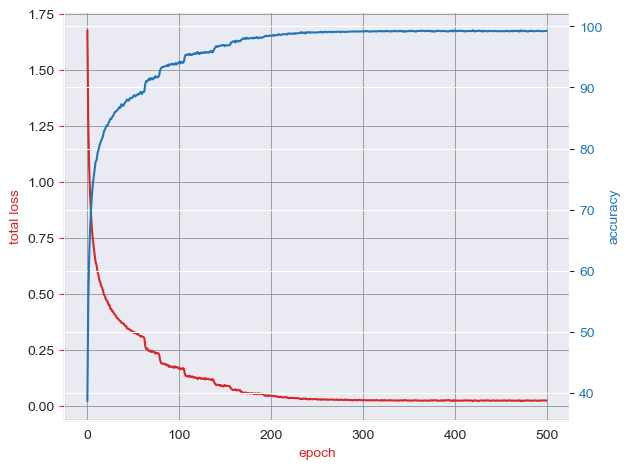

In [22]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(train_loss_history, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('total loss', color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.plot(train_accu_history, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#set grid color
ax1.grid(color='gray', linestyle='-', linewidth=0.5)
ax1.spines['bottom'].set_color('black')  # 设置x轴颜色
ax1.spines['left'].set_color('black')  # 设置y轴颜色

fig.tight_layout()

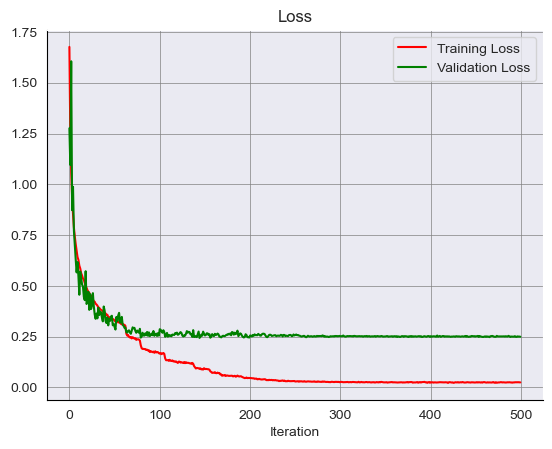

In [23]:
plt.plot(train_loss_history, 'r', label='Training Loss')
plt.plot(test_loss_history,  'g',  label='Validation Loss')
plt.xlabel("Iteration")
plt.title("Loss")
plt.grid(color='gray', linestyle='-', linewidth=0.5)
#set axis color
plt.gca().spines['bottom'].set_color('black')  # 设置x轴颜色
plt.gca().spines['left'].set_color('black')  # 设置y轴颜色
plt.legend()

In [25]:
#find highest accuracy
max_accu = max(test_accu_history)
max_accu_idx = test_accu_history.index(max_accu)
max_accu_idx

343

In [6]:
with open('predictions.pkl', 'rb') as f:
    loaded_list1 = pickle.load(f)

y_pred = loaded_list1[1]
y_true = loaded_list1[0]

In [27]:
model.eval()
all_predicted_output = []
true_labels = []
with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(testloader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        all_predicted_output.extend(predicted.cpu().numpy())
        true_labels.extend(labels.numpy())


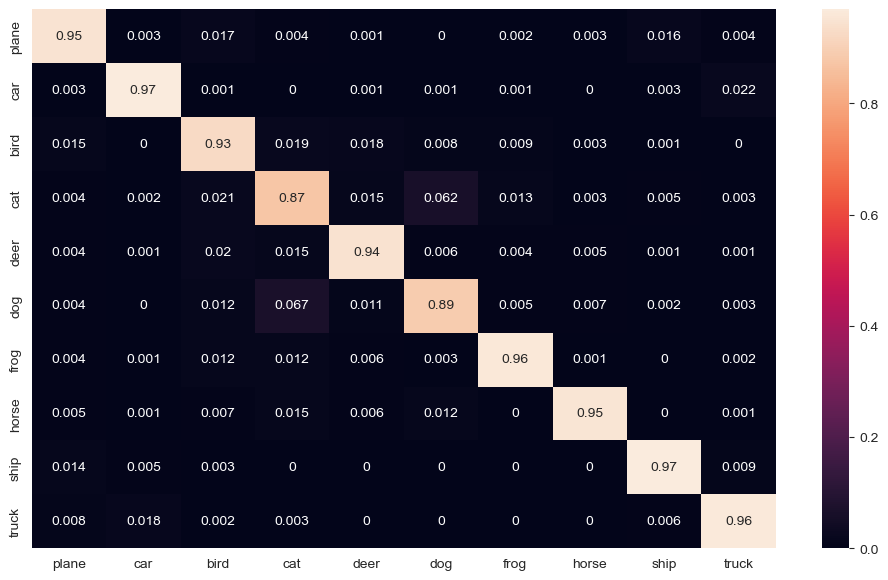

In [30]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')  # CIFAR-10 类别
cf_matrix = confusion_matrix(true_labels, all_predicted_output)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix) * 10, index=[i for i in classes],
                     columns=[i for i in classes])
plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

Files already downloaded and verified


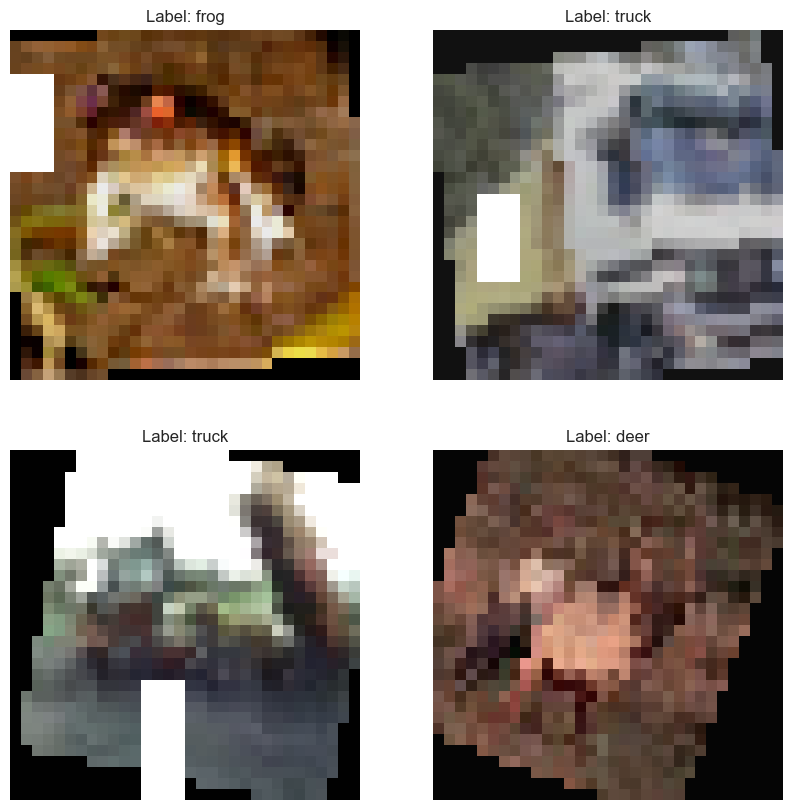

In [47]:
transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomRotation(25),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.75, scale=(0.02, 0.1), value=1.0, inplace=False)
    ])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

plt.figure(figsize=(10, 10))
for i in range(4):
    image, label = trainset[i]
    image = image.numpy().transpose((1, 2, 0))
    #convert from [0..1] to [0..255] for integers
    # image = (image * 255).astype(np.uint8)
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {classes[label]}")
    plt.axis("off")
plt.show()
